# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=False)

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
import shap
import matplotlib.pyplot as plt

from create_prediction import create_prediction
from draw_and_create_clusters import create_kmeans_clusters 
from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from create_target_columns import create_target_columns
from prepare_and_scale_data import prepare_and_scale_data
from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals
from print_examples import create_example_df, plot_difference
from create_new_values import create_new_values
from create_share_of_values import create_share_of_values
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the TensorBoard notebook extension
%load_ext tensorboard

pd.options.display.max_colwidth = 100

In [5]:
list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']

target_col_start = 'Äänet yhteensä lkm'
target = create_target_columns(list_of_parties, target_col_start)

In [6]:
#set values to feature engineering attributes

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'
test_size = 0.3
#Scalers attributes
kbest_score_func = mutual_info_regression 

metric = 'rmse'
Skfold=False
Verbose = False
testing=True
scaled = False

In [7]:
shap_values = []
shap_interaction_values = []
shap_expected_value = []

mymodel = {}
features_dict = {}
importance_dict = {}

data, X_scale, X = prepare_and_scale_data(stat, pd.DataFrame(), numeric_features=numeric_features, categorical_features=categorical_features)

i = 0
for t in target:
    params = {
        #Initial xgboost parameters to be automatically tuned
        'objective':'reg:squarederror',
        'booster' : 'gbtree',
        'eval_metric' : metric
        }
    d = pd.DataFrame()
    test = pd.DataFrame()
    filename_model = 'xgboost_political' + t
    print(t)
    d, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model,
                          path,
                          stat,
                          stat,
                          t,
                          kbest_score_func=kbest_score_func,
                          metric=metric,
                          params= params,
                          numeric_features=numeric_features,
                          categorical_features=categorical_features,
                          scaled=scaled,
                          k_selected = k_selected,
                          test_size = test_size,
                          Skfold=Skfold,
                          Verbose = Verbose,
                          testing=testing)
    
    
    data.loc[:,"Ennustettu "+ t] = y_pred
    
    filename_model = 'xgboost_political_shap' + t
    filename_shap =  'political_shap_shap' + t +'.npz'
    mymod, sh_values, shap_i_values, shap_e_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


    shap_values.append(sh_values)
    shap_interaction_values.append(shap_i_values)
    shap_expected_value.append(shap_e_value.item())
    
    mymodel[t] = mymod
    features_dict[t] = features_df
    importance_dict[t] = importance_df



Äänet yhteensä lkm VIHR
load model
load model
load shap files
Äänet yhteensä lkm KOK
load model
load model
load shap files
Äänet yhteensä lkm SDP
load model
load model
load shap files
Äänet yhteensä lkm KD
load model
load model
load shap files
Äänet yhteensä lkm KESK
load model
load model
load shap files
Äänet yhteensä lkm RKP
load model
load model
load shap files
Äänet yhteensä lkm PS
load model
load model
load shap files
Äänet yhteensä lkm VAS
load model
load model
load shap files


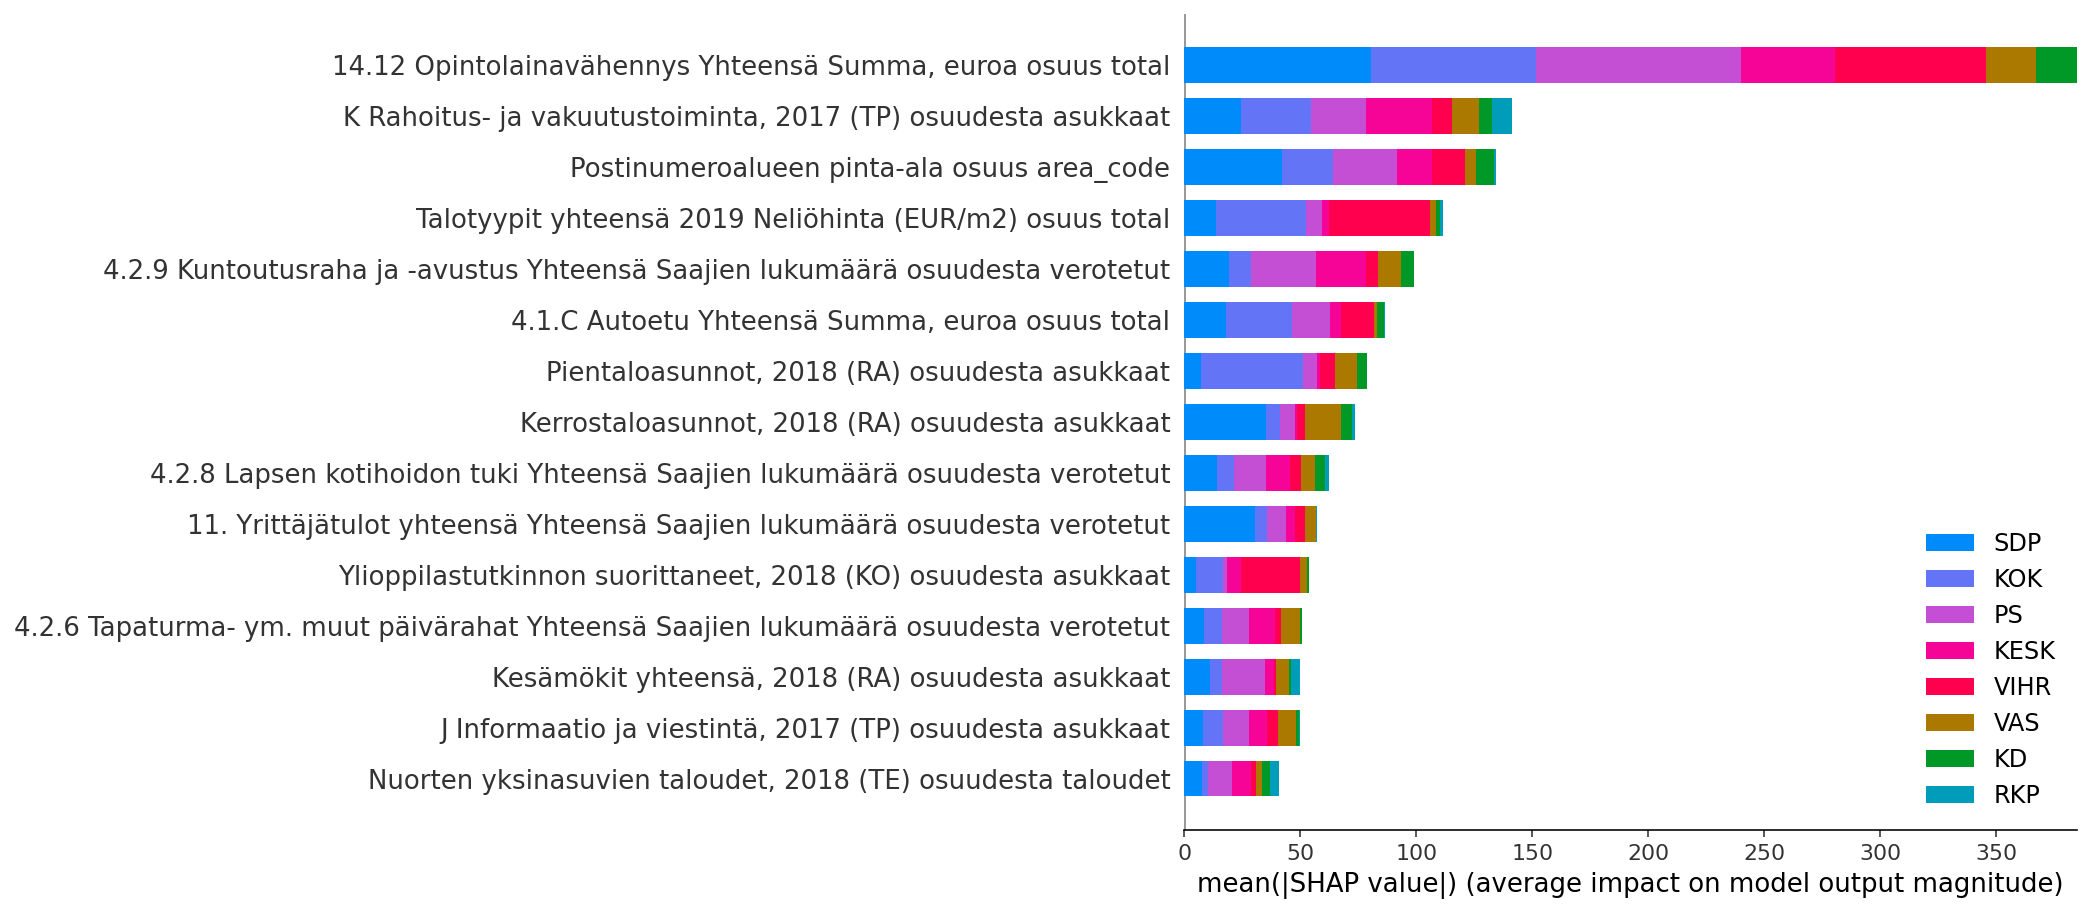

In [8]:
shap.summary_plot(shap_values, X,  max_display=15 ,class_names = list_of_parties)

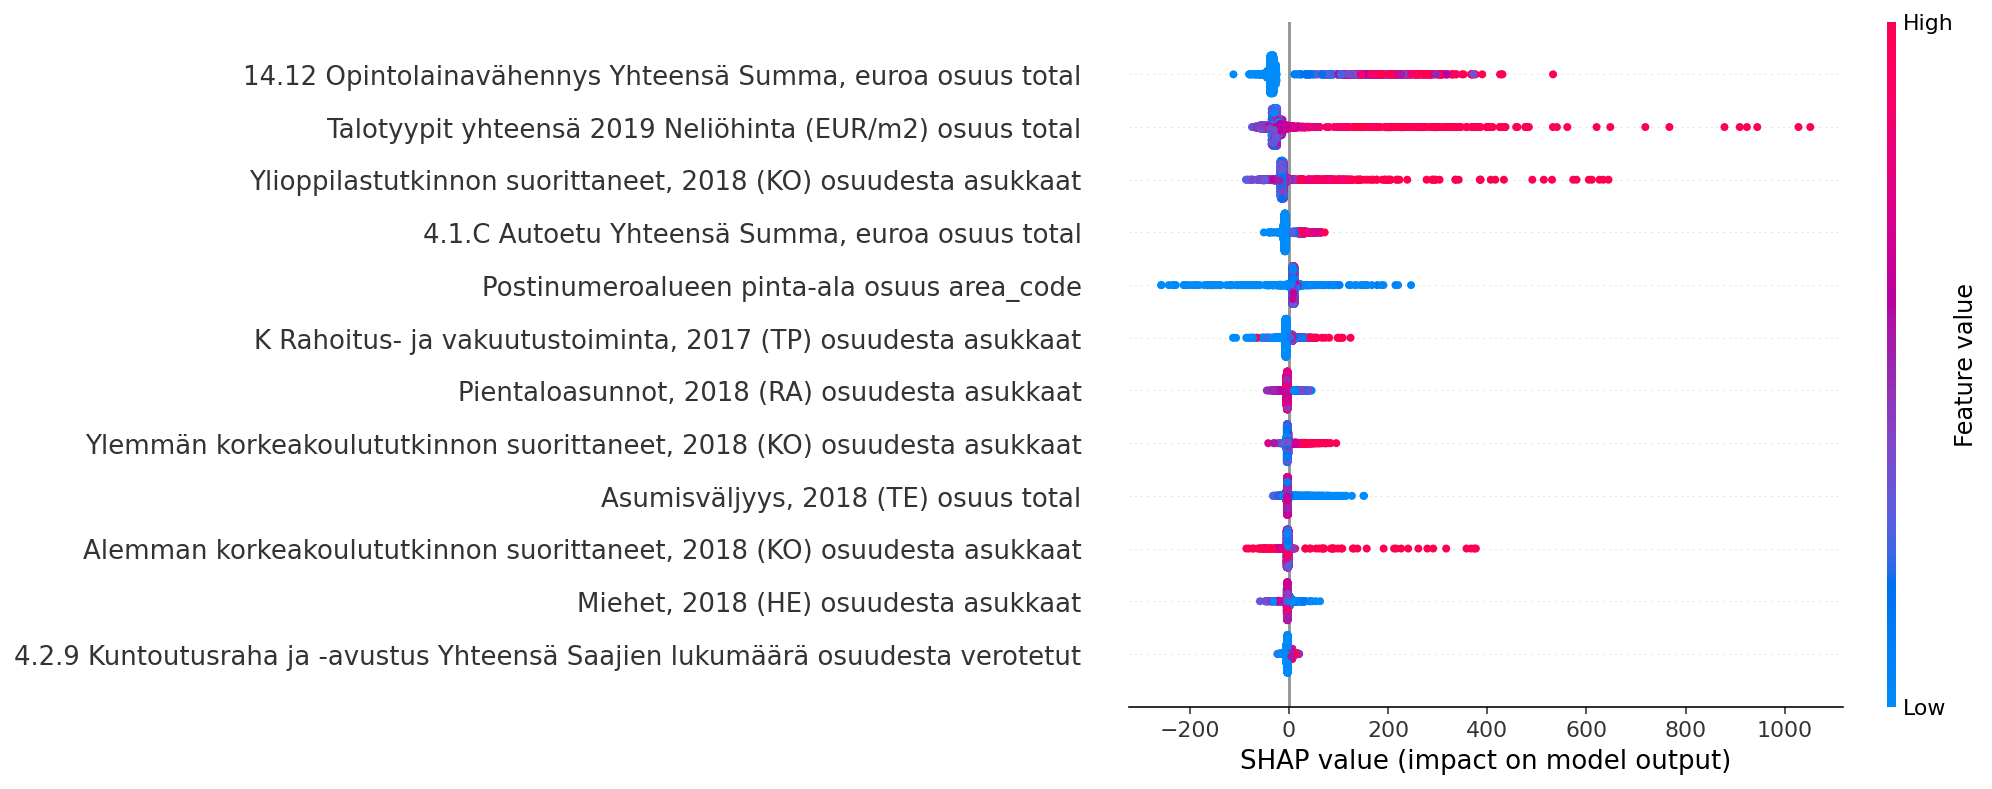

In [9]:
party ='VIHR'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = False

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


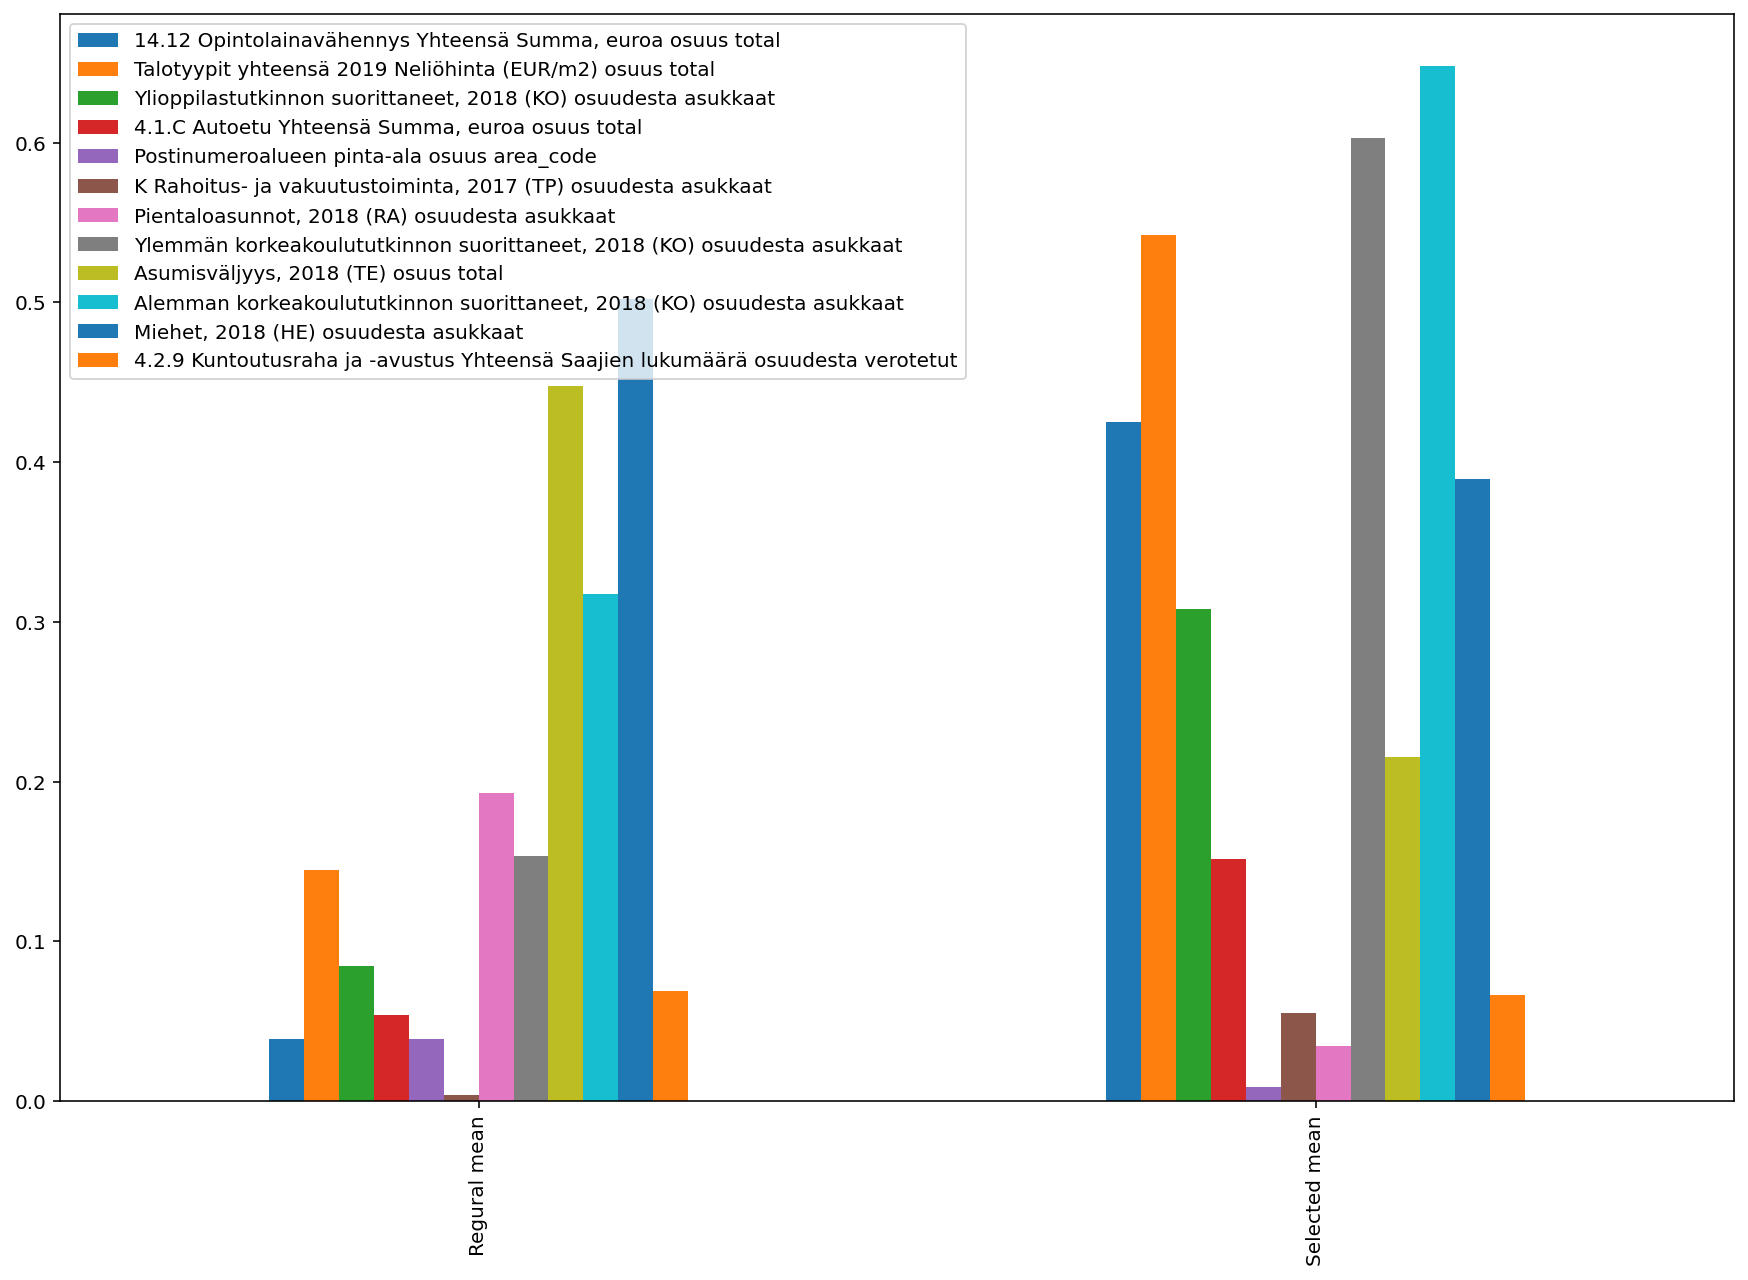

In [10]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

In [11]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
9          00200      HELSINKI         Helsinki                       15817.0   
27         00400      HELSINKI         Helsinki                        9621.0   
40         00580      HELSINKI         Helsinki                        2945.0   
0          00100      HELSINKI         Helsinki                       18427.0   
1002       33540       TAMPERE          Tampere                        9901.0   

     Suurin_puolue  Ääniosuus VIHR  Miehet, 2018 (HE) osuudesta asukkaat  \
9              KOK        0.257692                              0.459000   
27            VIHR        0.244165                              0.467623   
40            VIHR        0.297324                              0.481154   
0              KOK        0.258614                              0.470668   
1002          VIHR        0.248502                              0.458944   

      Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
9                                                     4.930300   
27                                                    3.384632   
40                                                    4.929492   
0                                                     5.927348   
1002                                                  2.637250   

      Asumisväljyys, 2018 (TE) osuus total  \
9                                 0.734962   
27                                0.669340   
40                                0.689027   
0                                 0.846519   
1002                              0.739337   

      Postinumeroalueen pinta-ala osuus area_code  \
9                                        0.000277   
27                                       0.000187   
40                                       0.000139   
0                                        0.000249   
1002                                     0.000107   

      Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
9                                                           0.111842   
27                                                          0.095832   
40                                                          0.156876   
0                                                           0.141966   
1002                                                        0.177861   

      Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
9                                                                    0.160397   
27                                                                   0.137512   
40                                                                   0.169100   
0                                                                    0.161882   
1002                                                                 0.164327   

      Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
9                                                                    0.297591   
27                                                                   0.173579   
40                                                                   0.187776   
0                                                                    0.324958   
1002                                                                 0.126856   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
9                                          0.031043   
27                                         0.007172   
40                                         0.004075   
0                                          0.000109   
1002                                       0.004646   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
9                                                          0.000822   
27                                                         0.001247   
40                                                         0.026825   
0                                             

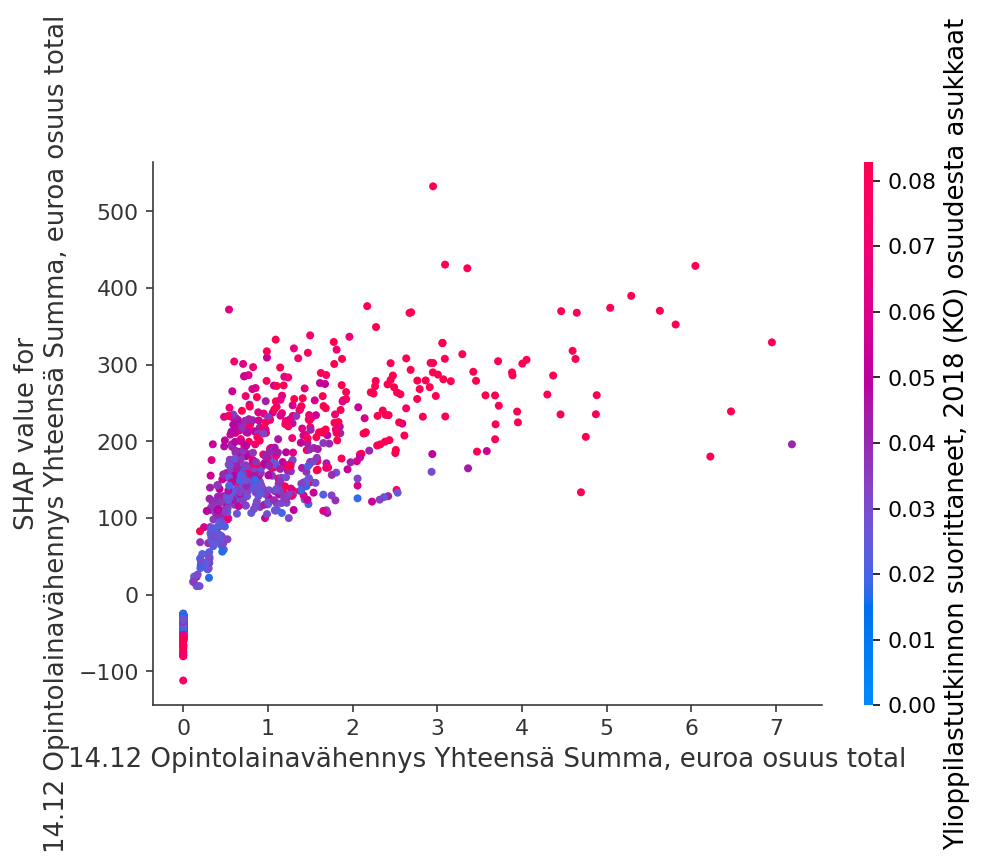

In [12]:
shap.dependence_plot("rank(0)", shap_values[shap_index], X)

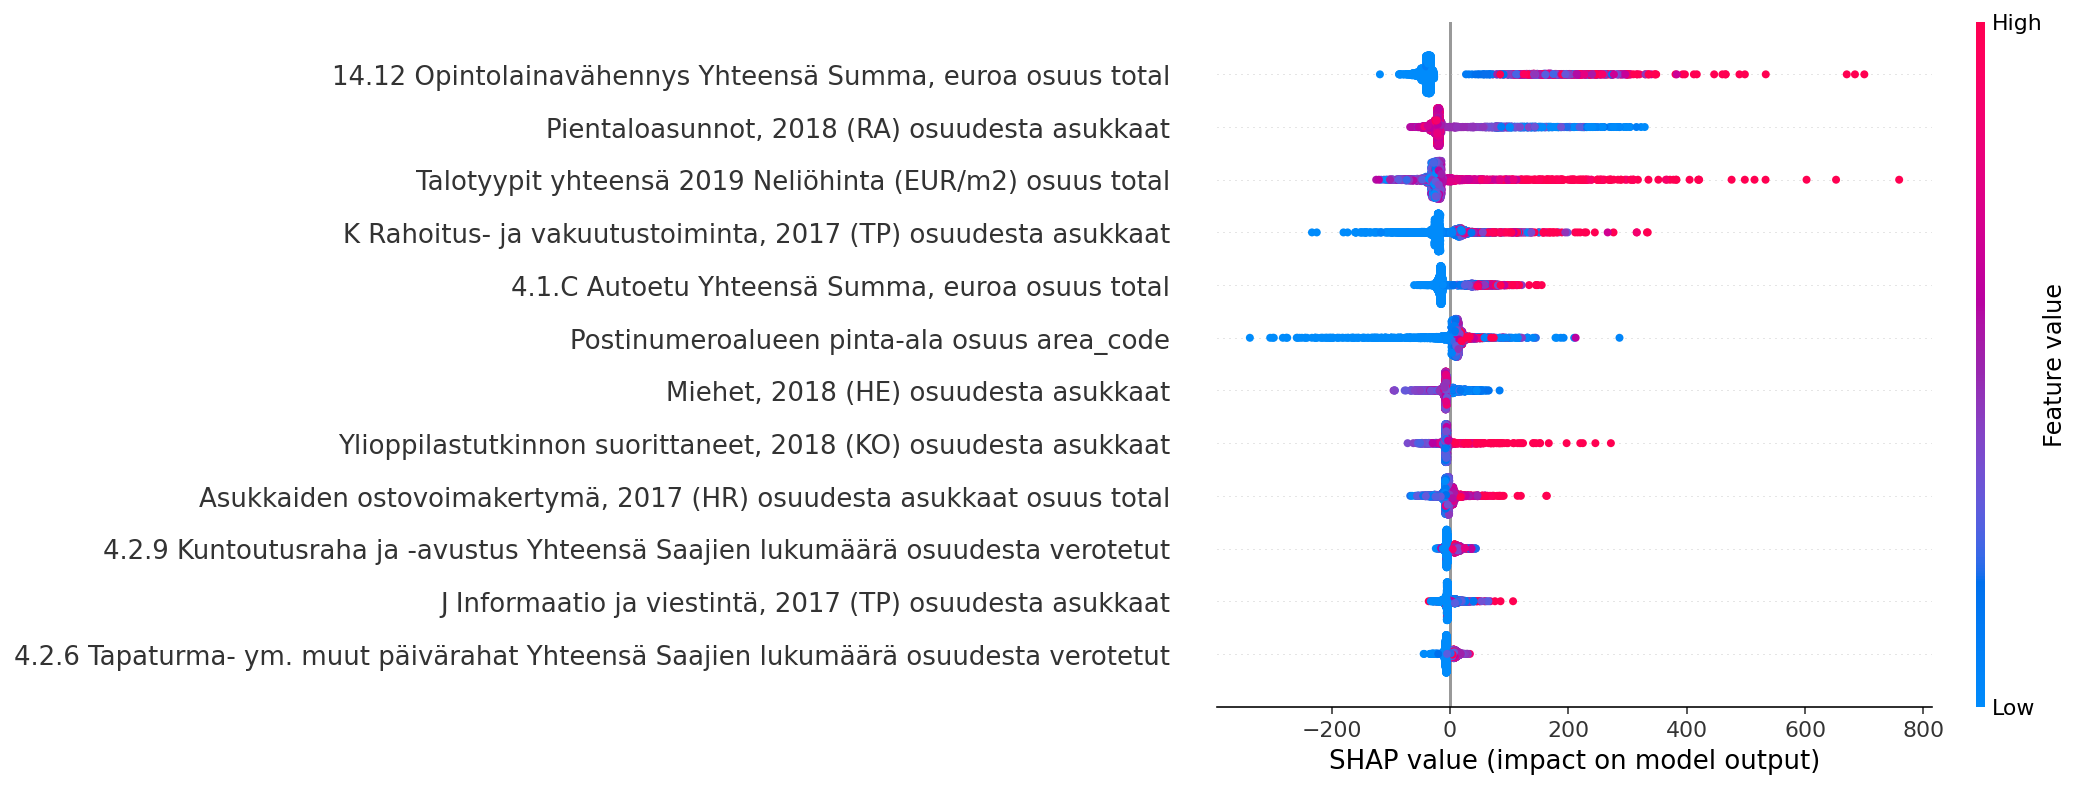

In [13]:
party ='KOK'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = True

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


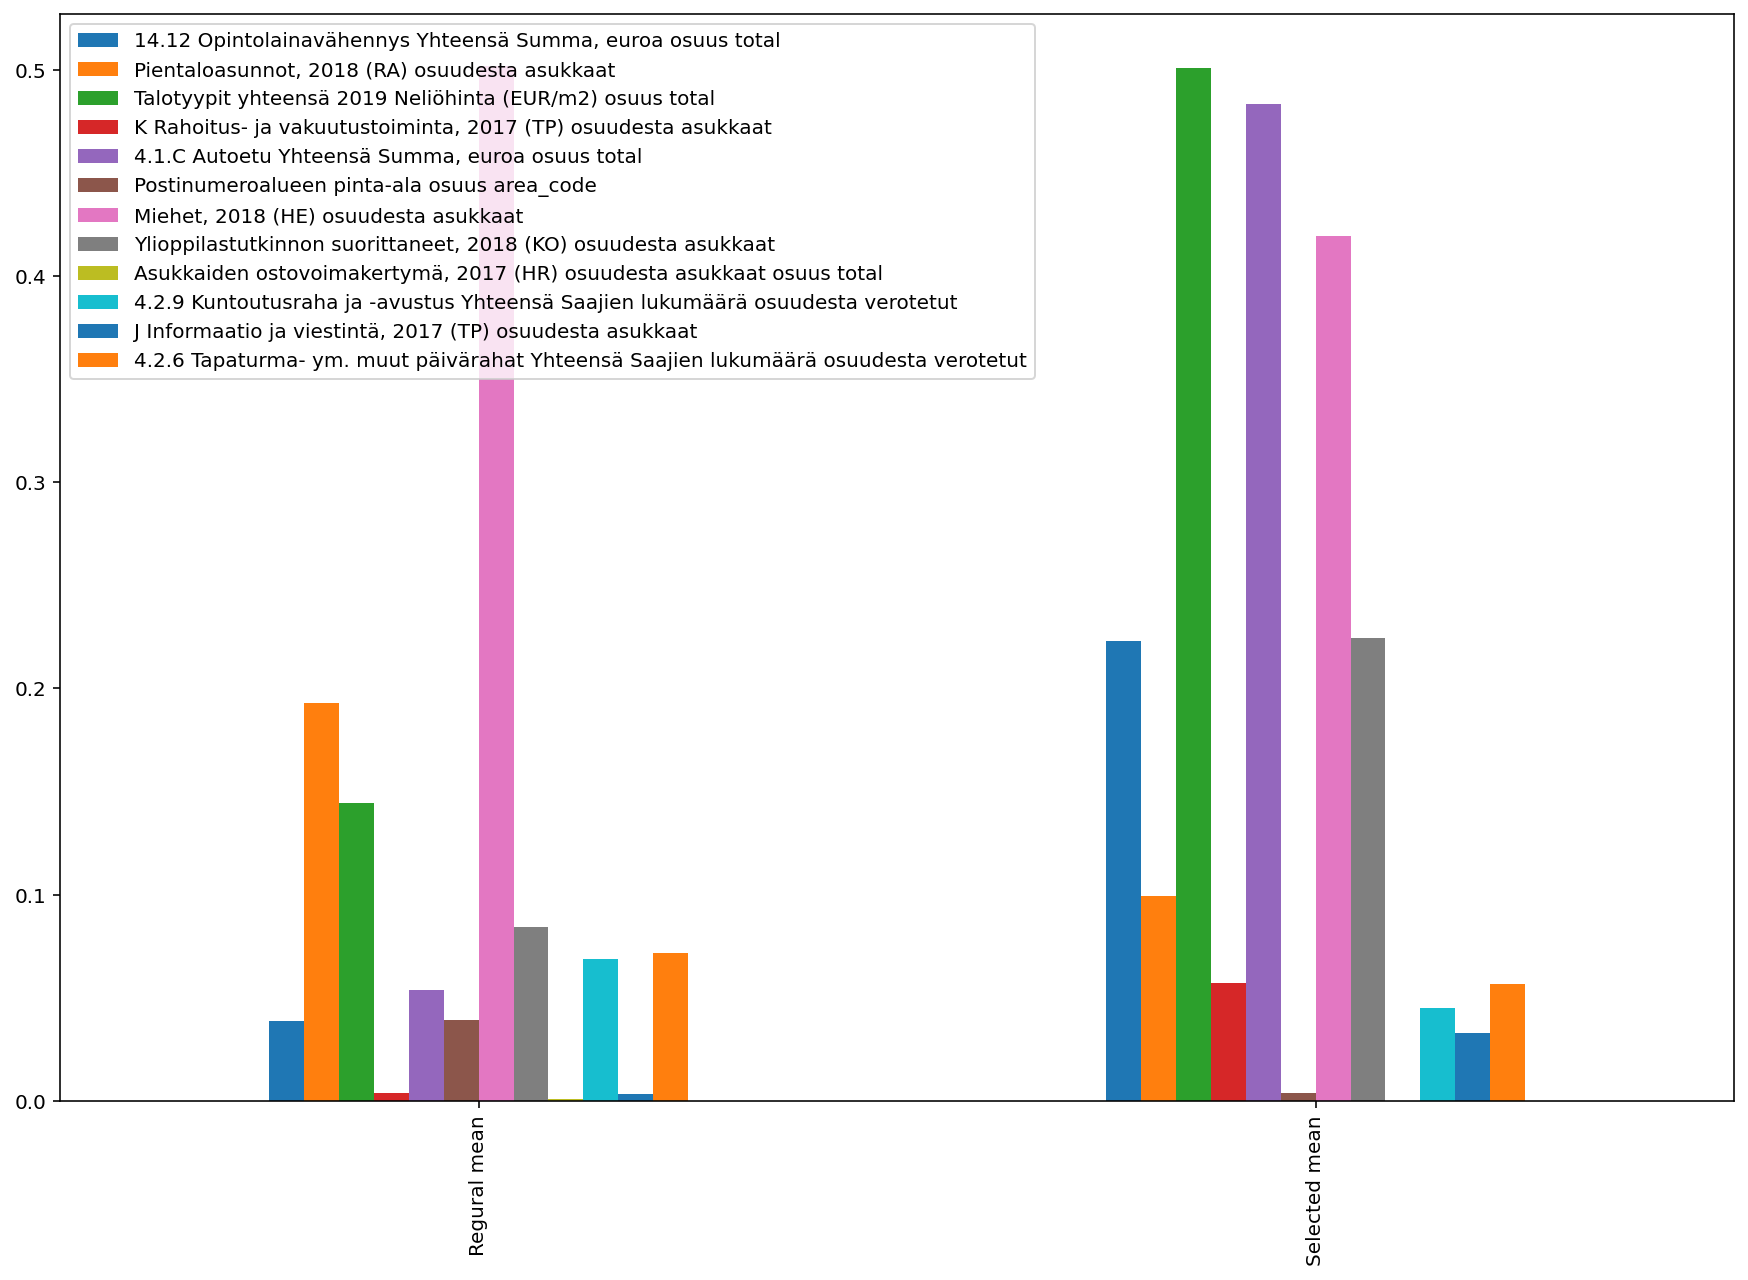

In [14]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

In [15]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
138       02140         ESPOO            Espoo                        3711.0   
10        00210      HELSINKI         Helsinki                        8509.0   
134       02100         ESPOO            Espoo                        5193.0   
151       02300         ESPOO            Espoo                        2575.0   
137       02130         ESPOO            Espoo                        6354.0   

    Suurin_puolue  Ääniosuus KOK  Miehet, 2018 (HE) osuudesta asukkaat  \
138           KOK       0.399906                              0.505524   
10            KOK       0.416110                              0.464097   
134           KOK       0.450712                              0.474677   
151           KOK       0.402049                              0.498641   
137           KOK       0.416899                              0.491187   

     Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
138                                                  2.443334   
10                                                   4.828494   
134                                                  3.982538   
151                                                  2.638866   
137                                                  3.343425   

     Postinumeroalueen pinta-ala osuus area_code  \
138                                     0.000257   
10                                      0.000156   
134                                     0.000202   
151                                     0.000183   
137                                     0.000280   

     Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
138                                                        0.075182   
10                                                         0.080856   
134                                                        0.103601   
151                                                        0.079223   
137                                                        0.085301   

     Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total  \
138                                                               0.017538   
10                                                                0.022368   
134                                                               0.021061   
151                                                               0.021061   
137                                                               0.020032   

     Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
138                                       0.290488   
10                                        0.004818   
134                                       0.057770   
151                                       0.354951   
137                                       0.228045   

     J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
138                                                  0.002695   
10                                                   0.081443   
134                                                  0.056807   
151                                                  0.003883   
137                                                  0.162260   

     K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
138                                                       0.001078   
10                                                        0.007874   
134                                                       0.253418   
151                                                       0.001553   
137                                                       0.000944   

     4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
138                                                                             0.006272   
10                                                                              0.003247   
134                                                              

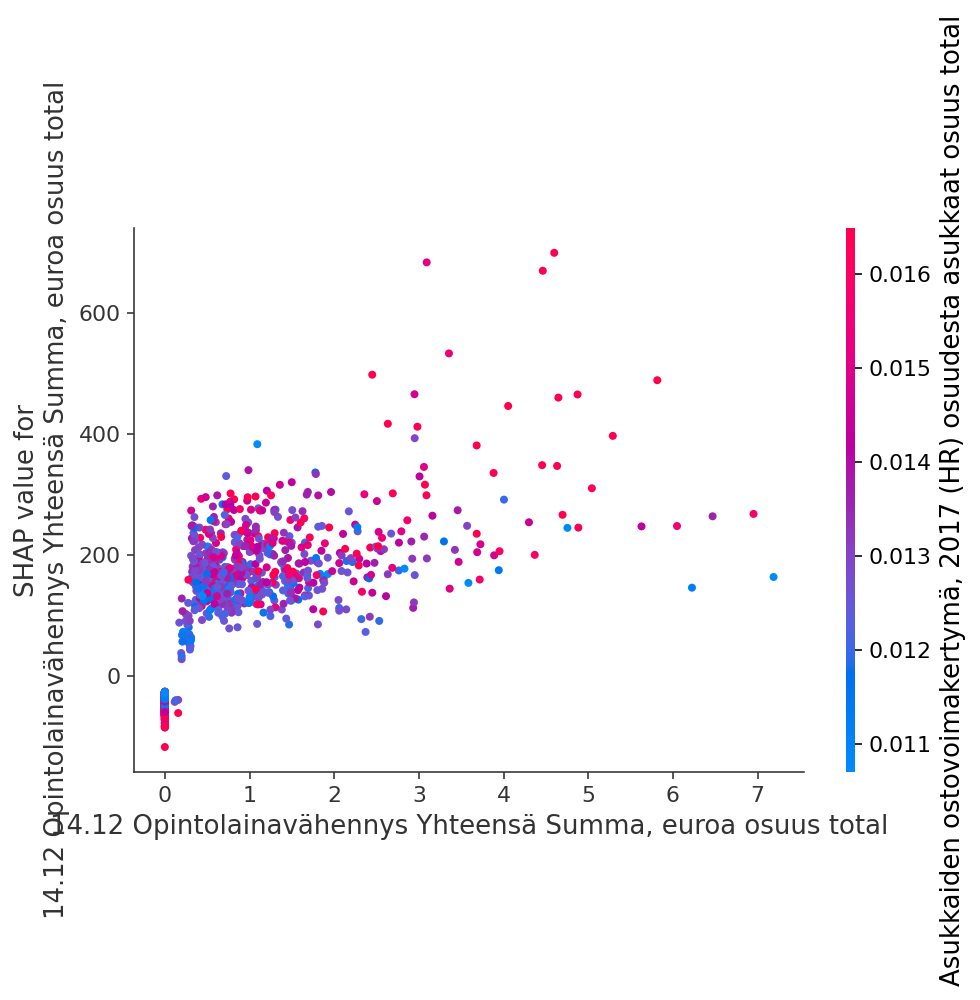

In [16]:
shap.dependence_plot("rank(0)", shap_values[shap_index], X)

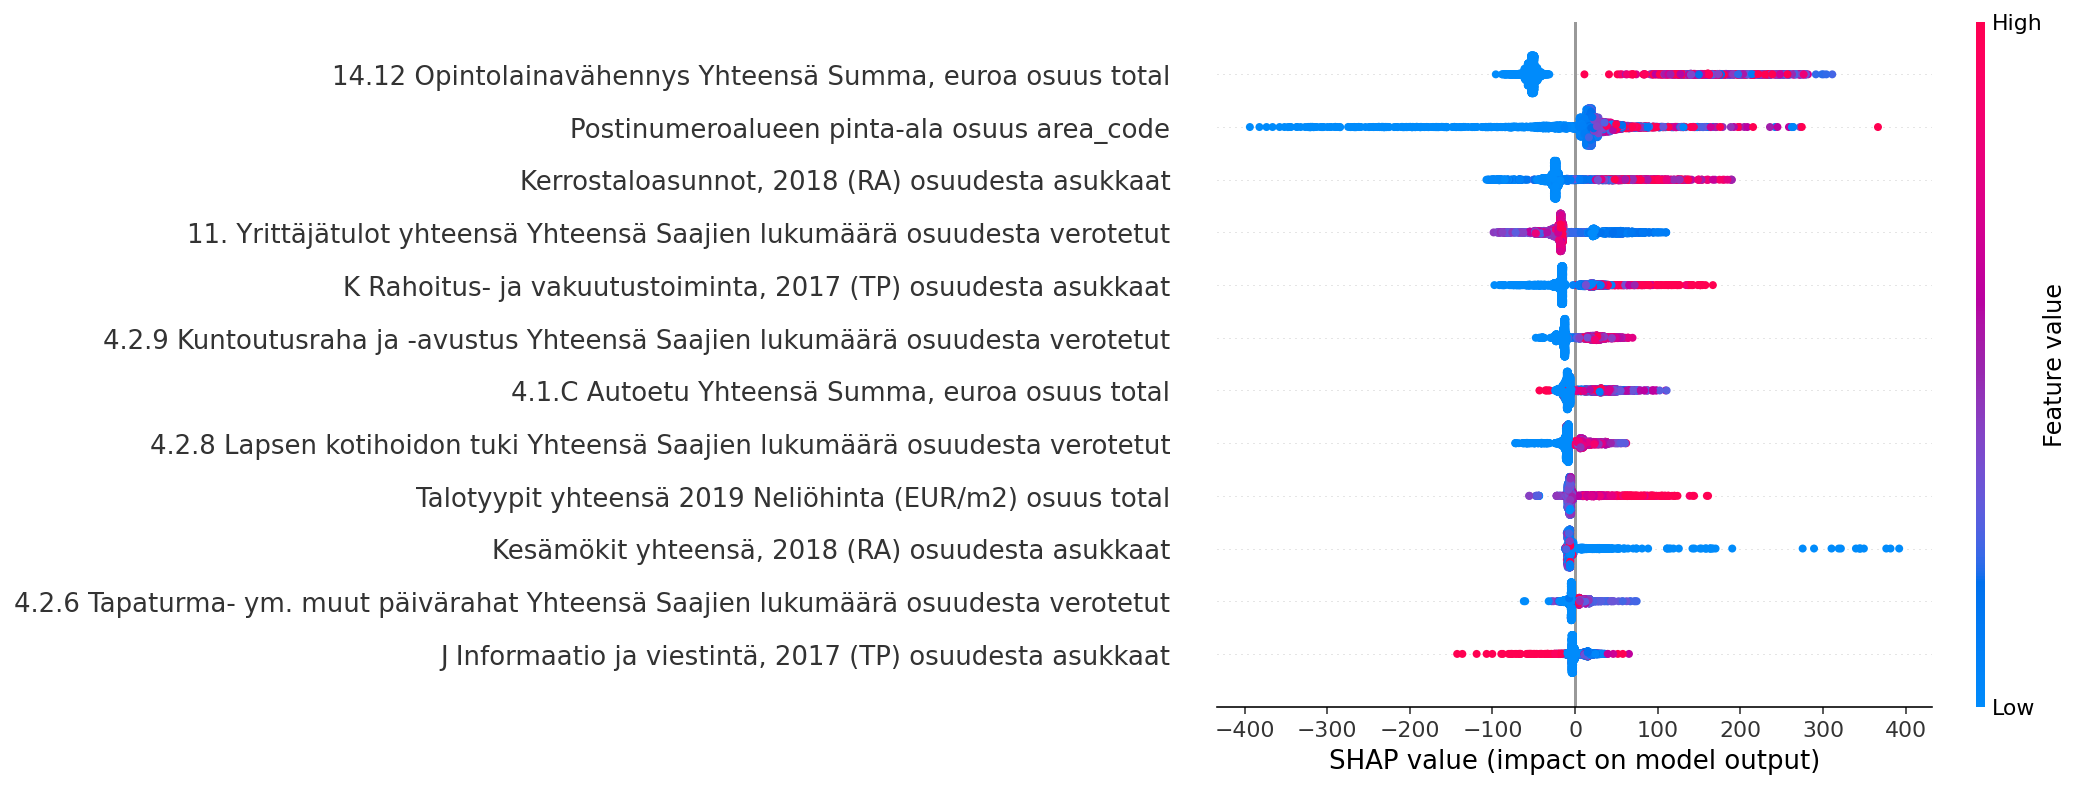

In [17]:
party ='SDP'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = True

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


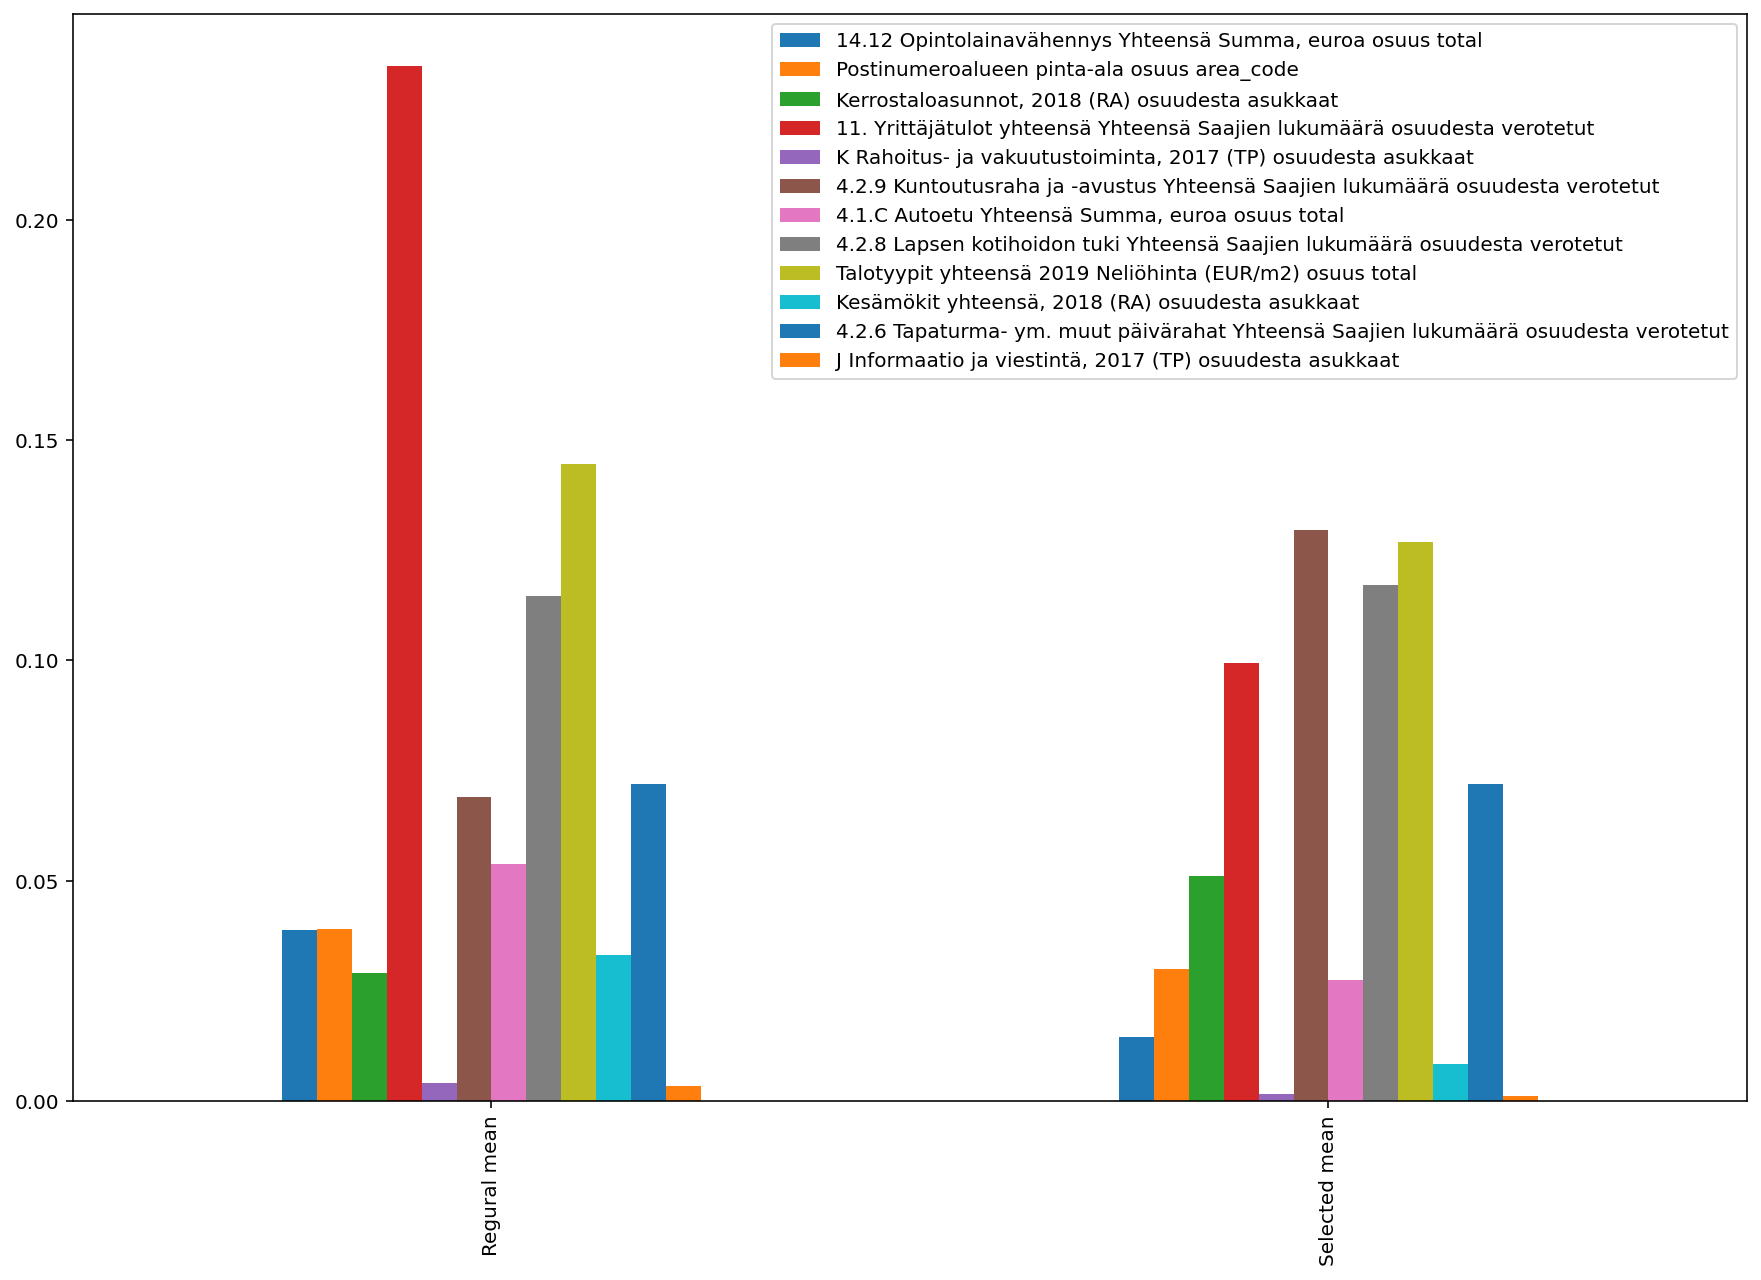

In [18]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

In [19]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
803        26910         UNAJA            Rauma                         673.0   
961        32740     SASTAMALA        Sastamala                        1733.0   
805        26950      VOILUOTO            Rauma                         390.0   
2329       81330    LUHTAPOHJA          Joensuu                          80.0   
795        26410         KAARO            Rauma                        1617.0   

     Suurin_puolue  Ääniosuus SDP  \
803            SDP       0.382789   
961            SDP       0.375000   
805            SDP       0.382692   
2329           SDP       0.394495   
795            SDP       0.389474   

      Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
803                                                   1.110974   
961                                                   0.561547   
805                                                   1.110974   
2329                                                  1.340440   
795                                                   1.110974   

      Postinumeroalueen pinta-ala osuus area_code  \
803                                      0.001481   
961                                      0.003271   
805                                      0.003123   
2329                                     0.003578   
795                                      0.002742   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
803                                          0.000000   
961                                          0.091748   
805                                          0.000000   
2329                                         0.000000   
795                                          0.000000   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
803                                           0.026746   
961                                           0.032891   
805                                           0.830769   
2329                                          0.487500   
795                                           0.214595   

      J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
803                                                   0.000000   
961                                                   0.000000   
805                                                   0.002564   
2329                                                  0.000000   
795                                                   0.000618   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
803                                                        0.000000   
961                                                        0.002885   
805                                                        0.000000   
2329                                                       0.000000   
795                                                        0.000000   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
803                                                                    0.092224   
961                                                                    0.086420   
805                                                                    0.135693   
2329                                                                   0.000000   
795                                                                    0.058185   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
803                                                                              0.000000   
961                                                                              0.006498   
805                                                                              0.000000   
2329                                                                             0.000000   
795                                                                              0.008534   

     

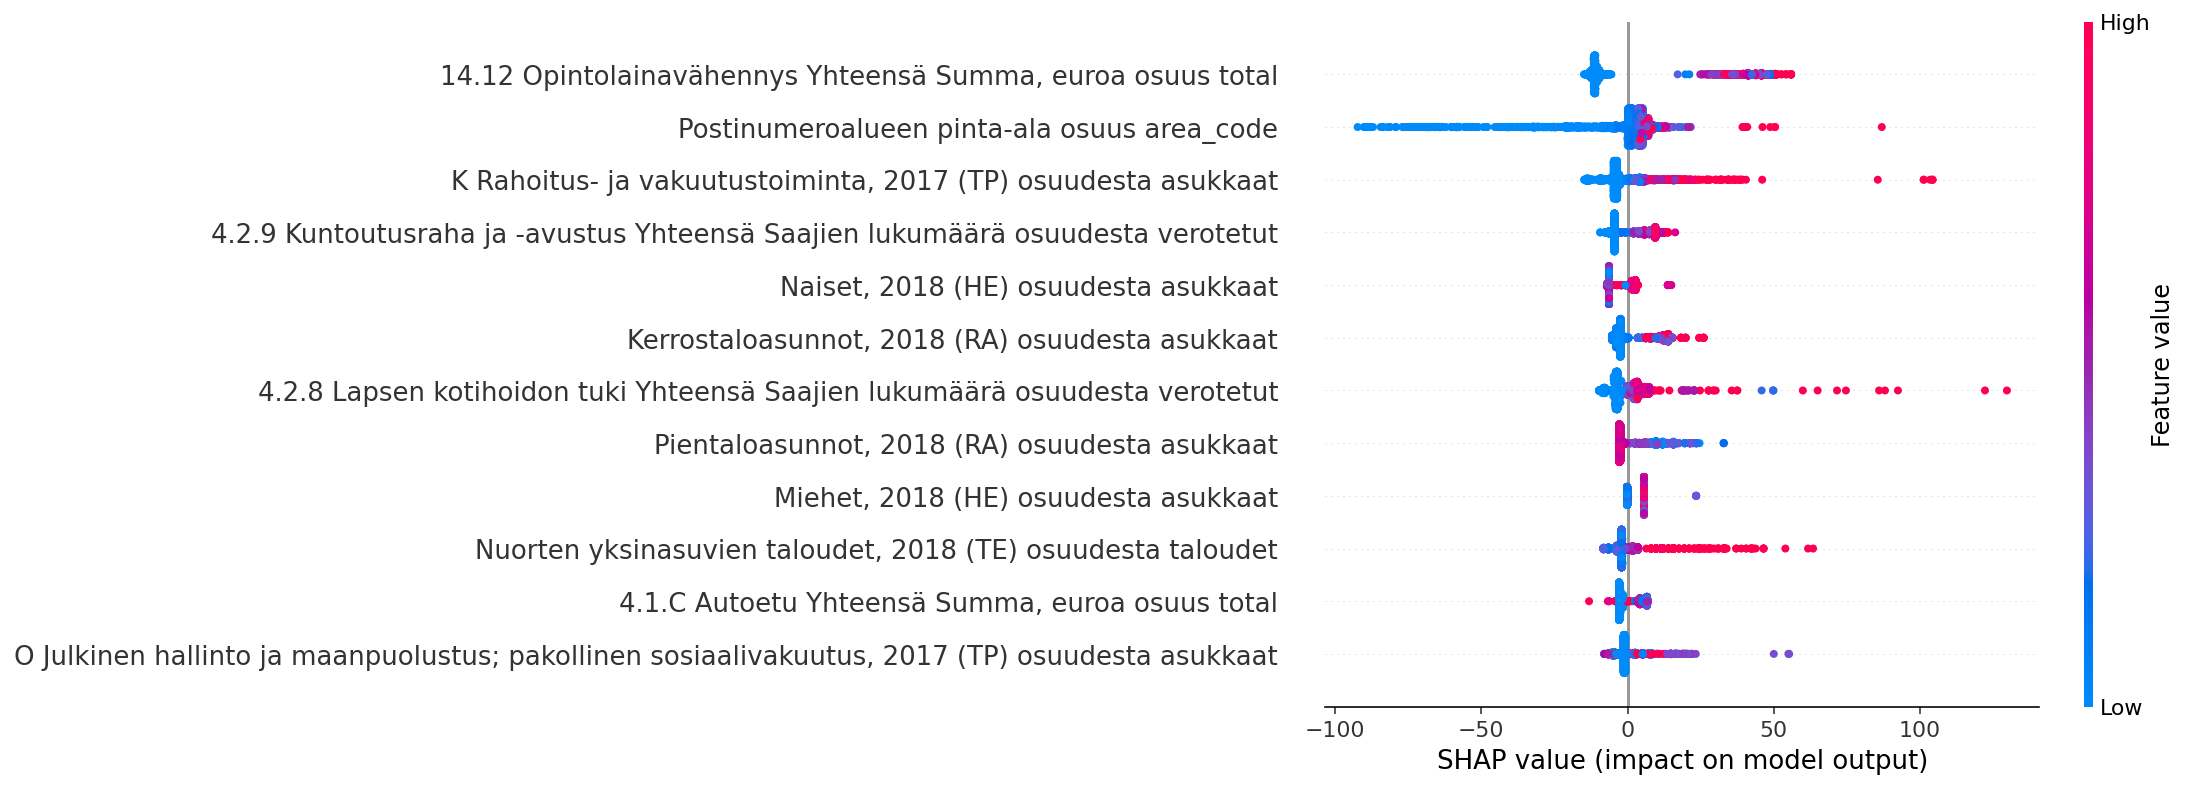

In [20]:
party ='KD'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = True

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


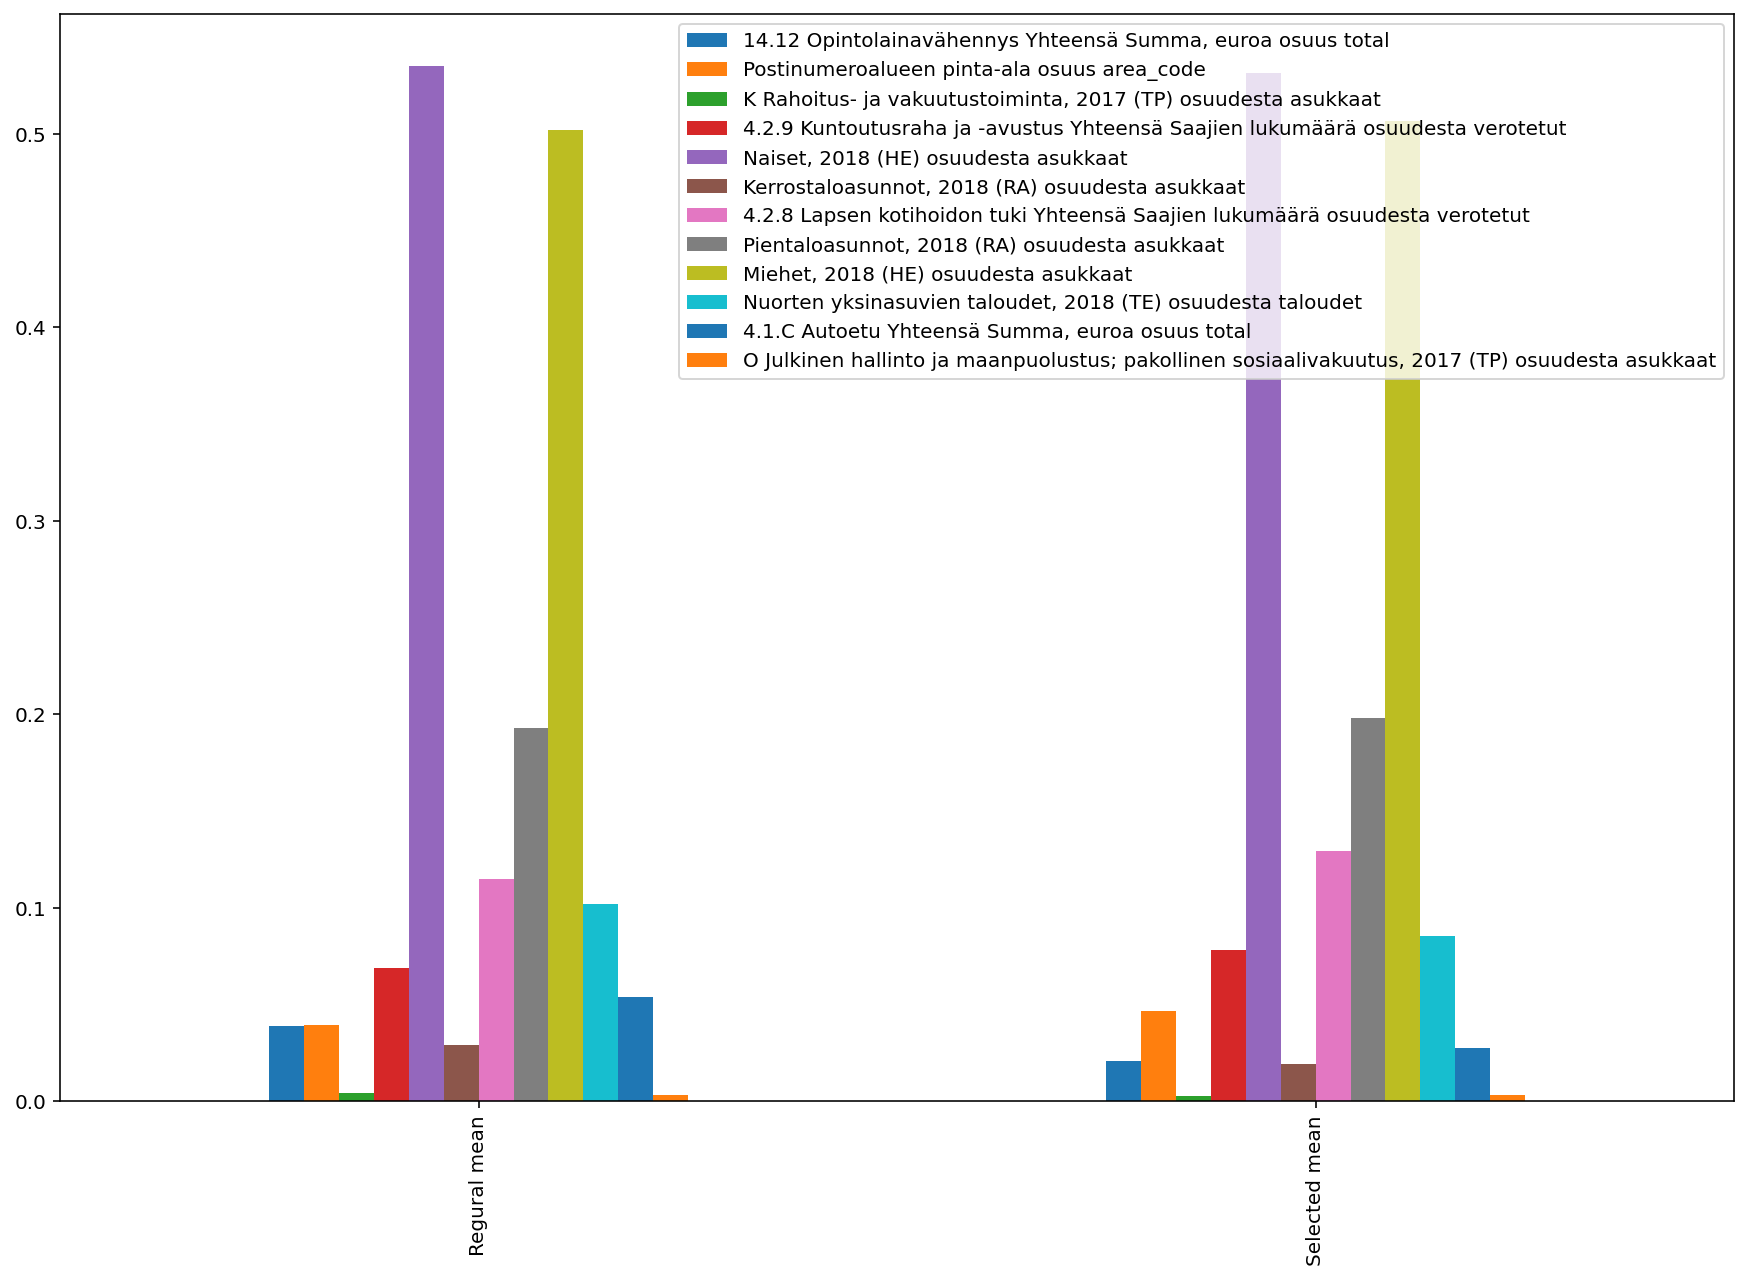

In [21]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

In [22]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2159       73120        NERKOO       Lapinlahti                         517.0   
2180       72600       KEITELE          Keitele                        1887.0   
2320       80330       REIJOLA          Joensuu                        2327.0   
2190       73850    ALA-LUOSTA       Rautavaara                          89.0   
2017       68910     PÄNNÄINEN        Pedersöre                        1299.0   

     Suurin_puolue  Ääniosuus KD  Miehet, 2018 (HE) osuudesta asukkaat  \
2159          KESK      0.148026                              0.537718   
2180          KESK      0.101449                              0.494436   
2320           SDP      0.091809                              0.500645   
2190          KESK      0.089744                              0.573034   
2017           RKP      0.113456                              0.508853   

      Naiset, 2018 (HE) osuudesta asukkaat  \
2159                              0.462282   
2180                              0.505564   
2320                              0.499355   
2190                              0.426966   
2017                              0.491147   

      Postinumeroalueen pinta-ala osuus area_code  \
2159                                     0.002845   
2180                                     0.018176   
2320                                     0.001824   
2190                                     0.004851   
2017                                     0.006495   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
2159                                         0.000000   
2180                                         0.075252   
2320                                         0.028363   
2190                                         0.000000   
2017                                         0.040801   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
2159                                       0.431335   
2180                                       0.541600   
2320                                       0.447787   
2190                                       0.606742   
2017                                       0.368745   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
2159                                                        0.00000   
2180                                                        0.00424   
2320                                                        0.00000   
2190                                                        0.00000   
2017                                                        0.00000   

      O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat  \
2159                                                                                         0.000000   
2180                                                                                         0.011129   
2320                                                                                         0.000000   
2190                                                                                         0.000000   
2017                                                                                         0.042340   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
2159                                                     0.009709   
2180                                                     0.043750   
2320                                                     0.085147   
2190                                                     0.000000   
2017                                                     0.041494   

      4.2.8 Lapsen kotihoidon tuki Yhteensä Saajien lukumäärä osuudesta verotetut  \
2159                                                                     0.027569   
2180                                                                     0.018496   
2320                                                                     0.

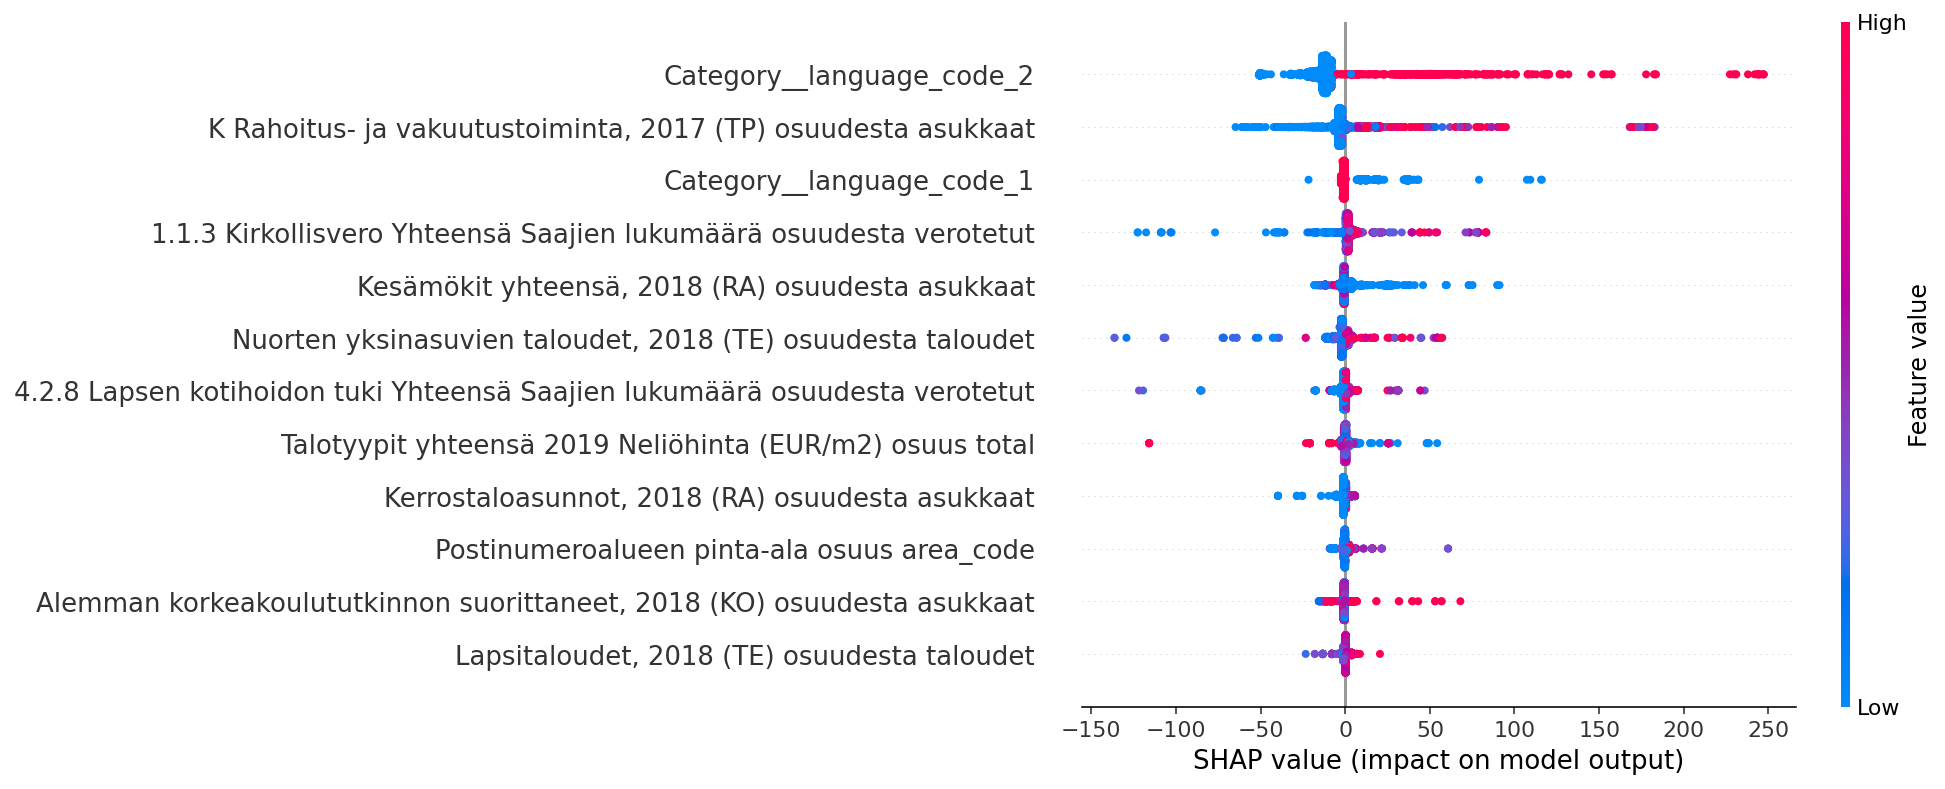

In [23]:
party ='RKP'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = True

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


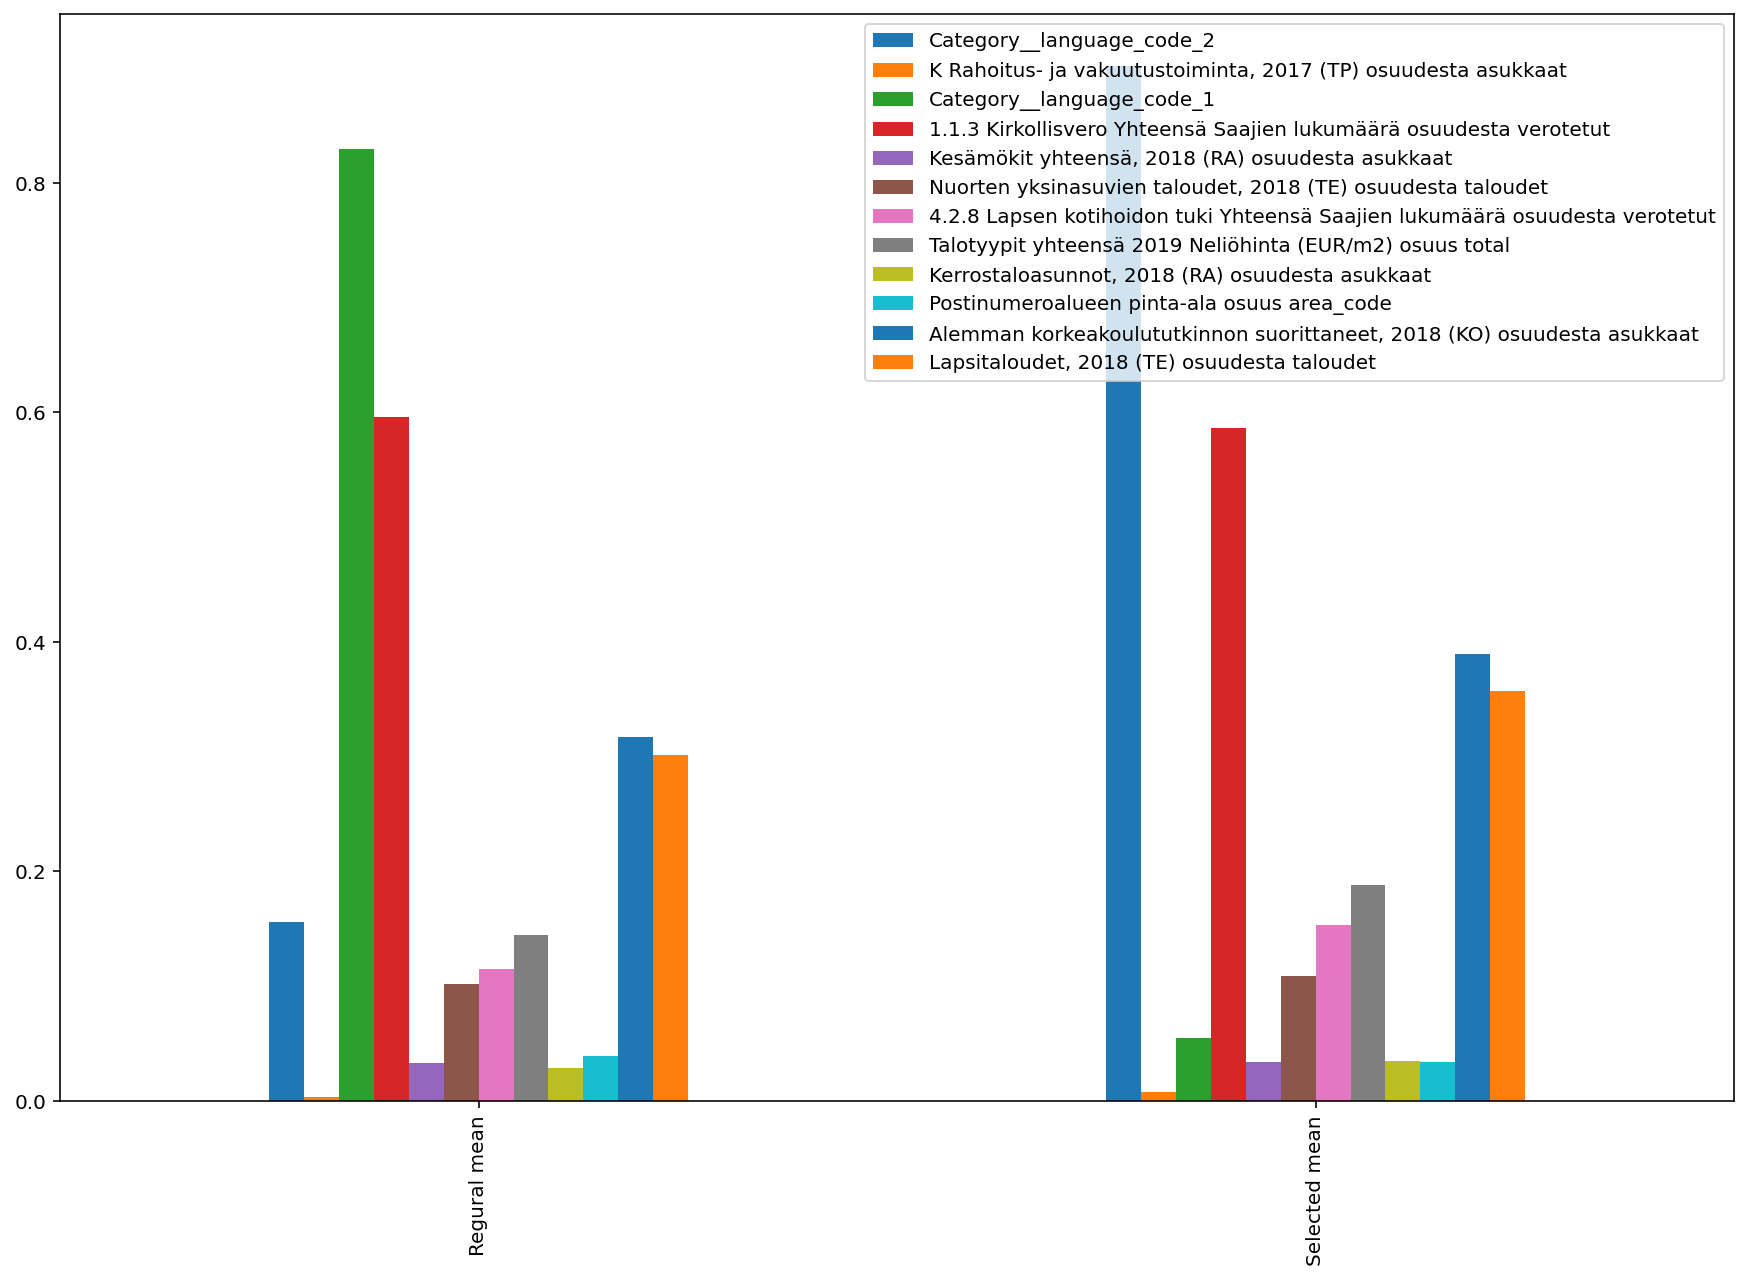

In [24]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

In [25]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
374        10710   SNAPPERTUNA        Raasepori                         368.0   
1922       65350         VAASA            Vaasa                        3772.0   
292        06830   KULLOONKYLÄ           Porvoo                        1060.0   
286        06400        PORVOO           Porvoo                        7377.0   
1899       64510       NÄMPNÄS           Närpes                         429.0   

     Suurin_puolue  Ääniosuus RKP  \
374            RKP       0.621212   
1922           SDP       0.184601   
292            RKP       0.299094   
286            SDP       0.149058   
1899           RKP       0.847390   

      Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
374                                                   1.113398   
1922                                                  1.089158   
292                                                   1.944810   
286                                                   1.779174   
1899                                                  0.000000   

      Postinumeroalueen pinta-ala osuus area_code  \
374                                      0.005714   
1922                                     0.000515   
292                                      0.003771   
286                                      0.000756   
1899                                     0.006511   

      Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
374                                                                  0.095109   
1922                                                                 0.101538   
292                                                                  0.093396   
286                                                                  0.089467   
1899                                                                 0.079254   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
374                                          0.000000   
1922                                         0.502121   
292                                          0.000000   
286                                          0.240342   
1899                                         0.000000   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
374                                           2.097826   
1922                                          0.000530   
292                                           0.082075   
286                                           0.002304   
1899                                          0.743590   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
374                                                        0.000000   
1922                                                       0.000265   
292                                                        0.000000   
286                                                        0.000136   
1899                                                       0.000000   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
374                                                      0.047904   
1922                                                     0.144135   
292                                                      0.012077   
286                                                      0.099044   
1899                                                     0.038889   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
374                                      0.215569   
1922                                     0.209742   
292                                      0.333333   
286                                      0.273675   
1899                                     0.266667   

      1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä osuudesta verotetut  \
374                                                             0.570492   
1922                                                            0.589219   
292        

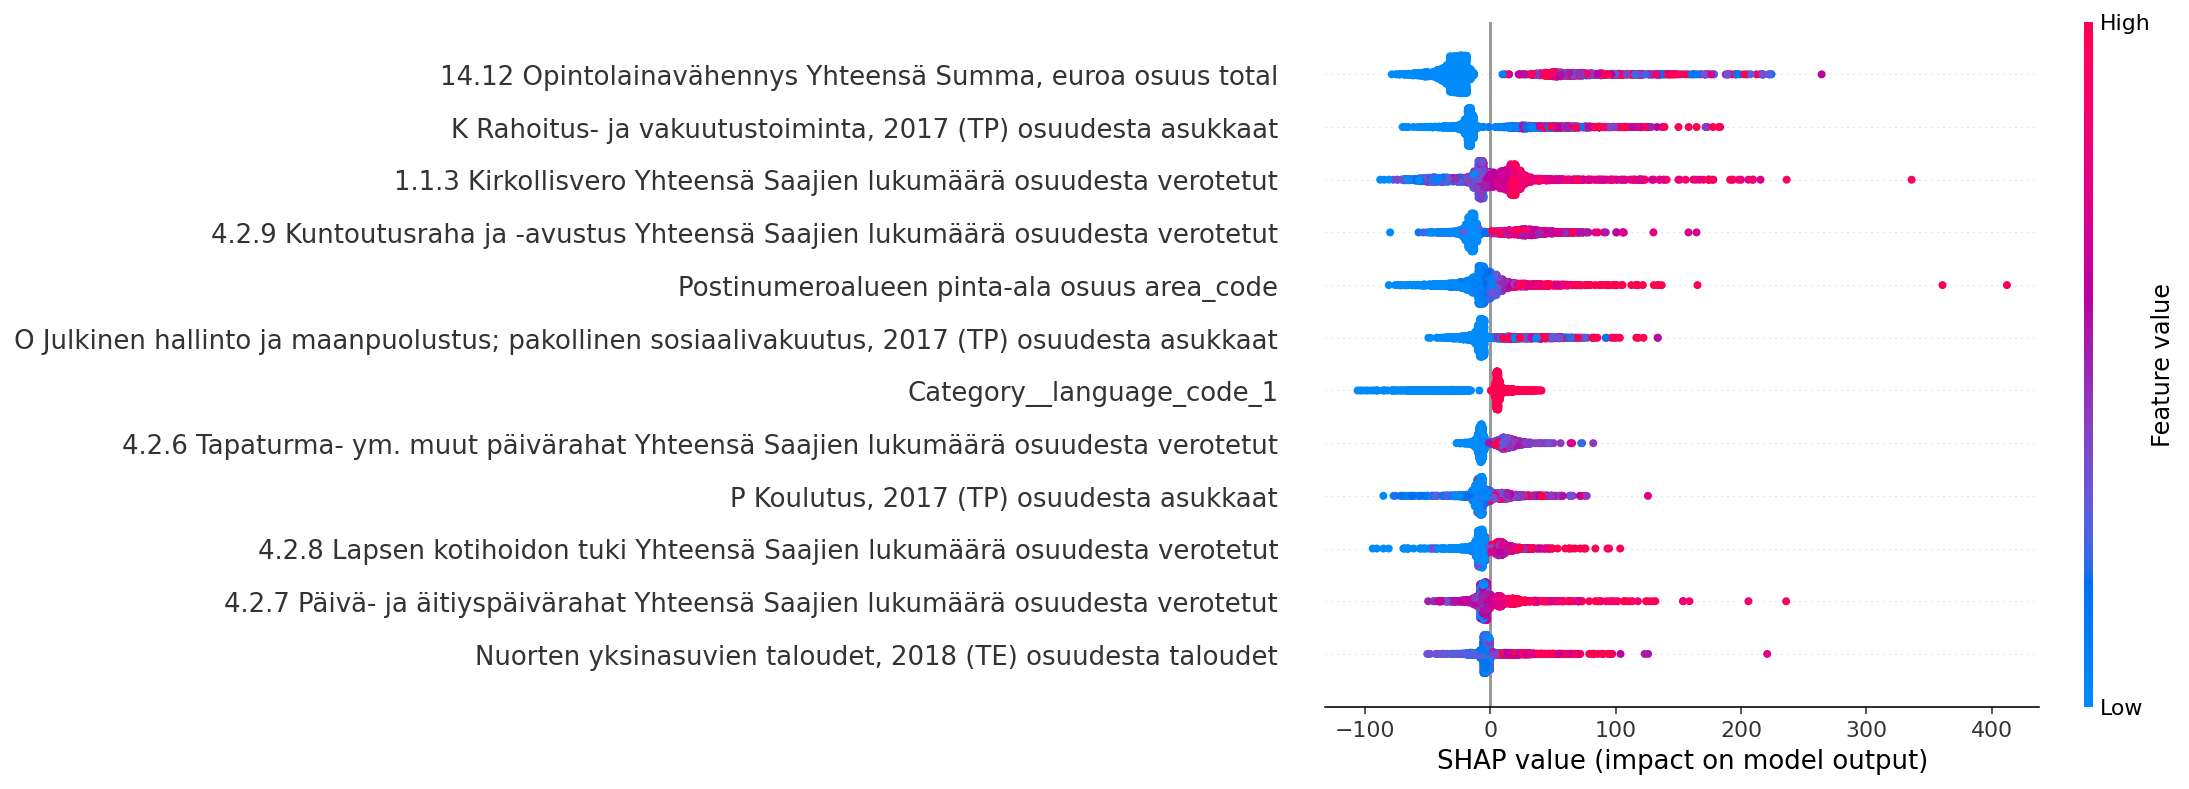

In [26]:
party ='KESK'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = True

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


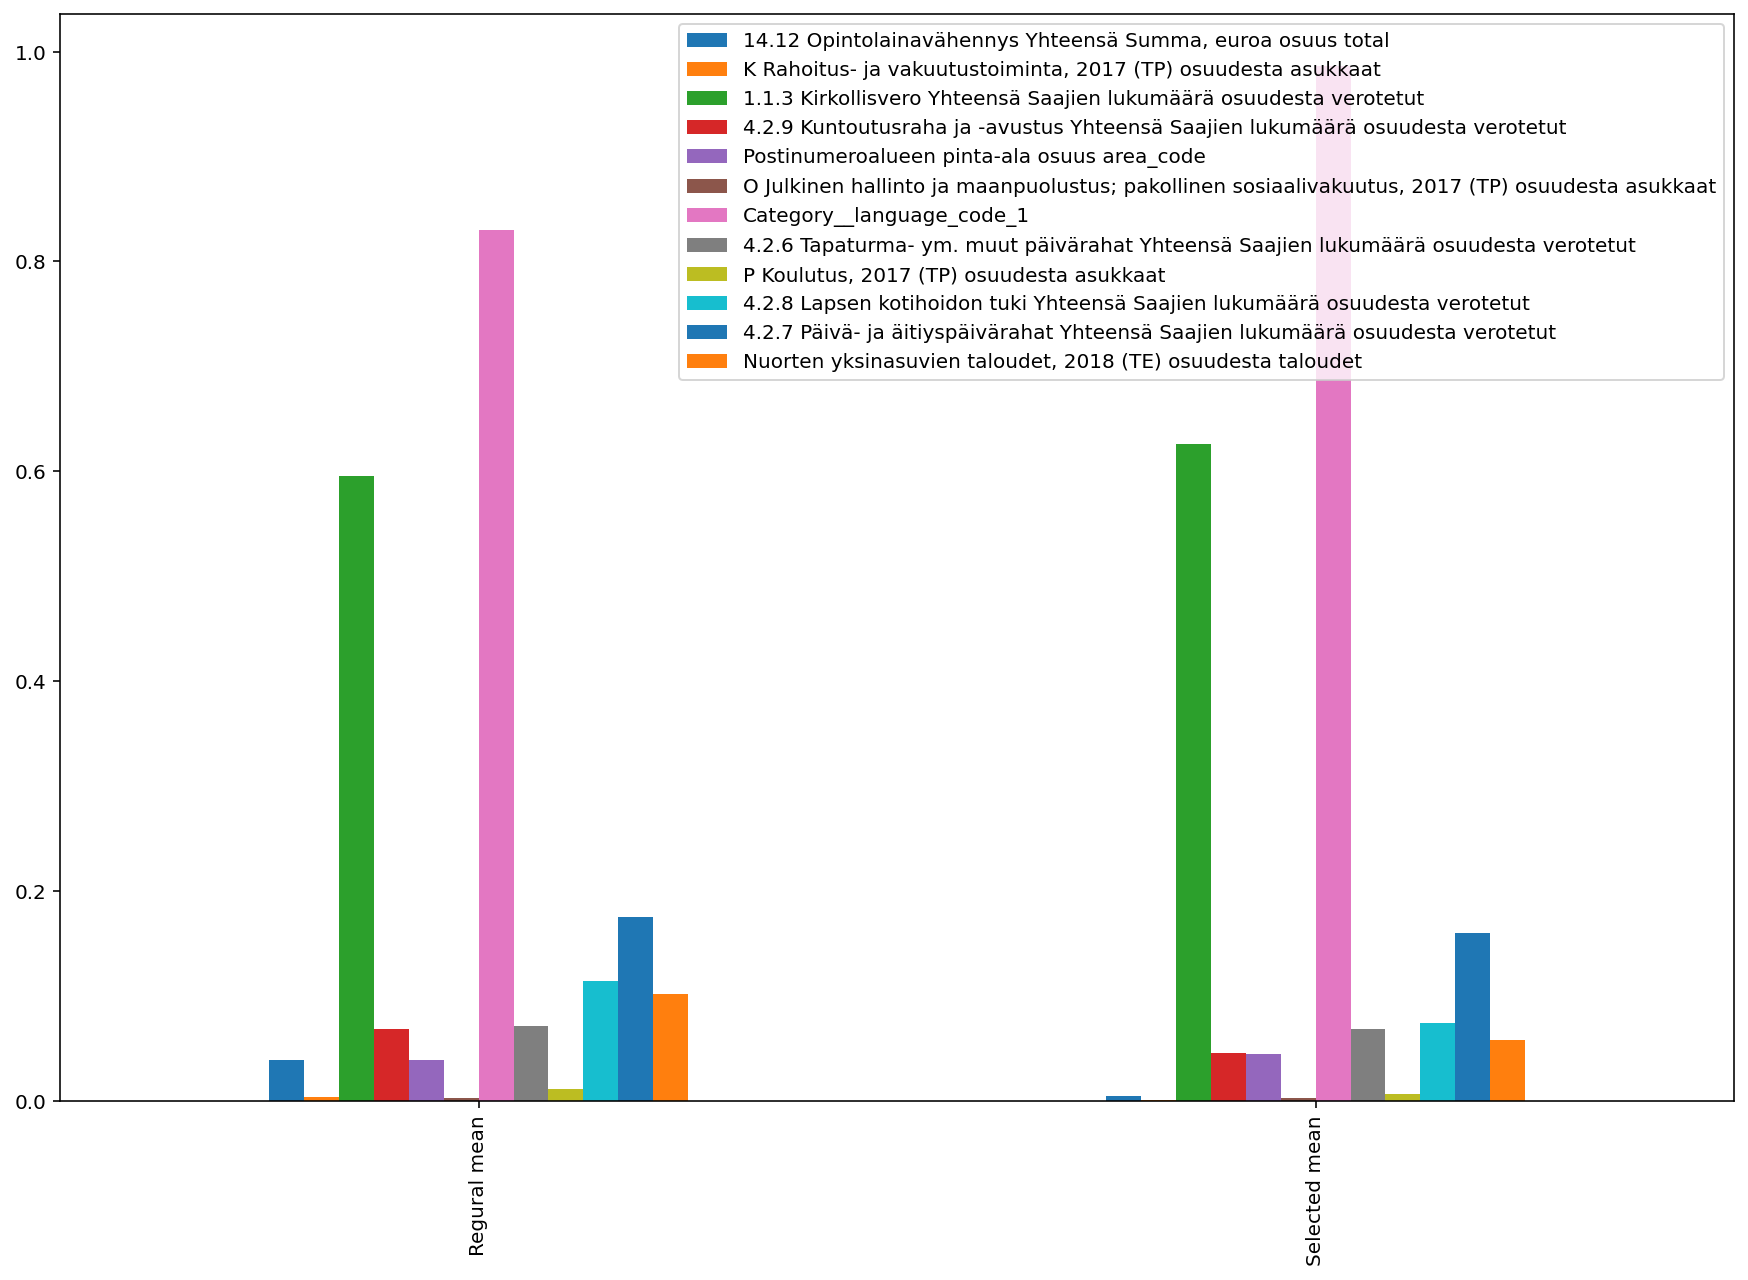

In [27]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

In [28]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1581       54770  HEITUINLAHTI      Savitaipale                         510.0   
1845       62740   KOSKENVARSI         Alajärvi                         208.0   
1600       56120     SALOSAARI       Ruokolahti                         822.0   
2904       97820    PERÄ-POSIO            Posio                          88.0   
2758       95675   MELTOSJÄRVI        Ylitornio                         132.0   

     Suurin_puolue  Ääniosuus KESK  \
1581          KESK        0.290135   
1845          KESK        0.349206   
1600           SDP        0.277778   
2904          KESK        0.540541   
2758          KESK        0.456522   

      Postinumeroalueen pinta-ala osuus area_code  \
1581                                     0.031218   
1845                                     0.000485   
1600                                     0.007135   
2904                                     0.001645   
2758                                     0.002111   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
1581                                                            0.0   
1845                                                            0.0   
1600                                                            0.0   
2904                                                            0.0   
2758                                                            0.0   

      O Julkinen hallinto ja maanpuolustus; pakollinen sosiaalivakuutus, 2017 (TP) osuudesta asukkaat  \
1581                                                                                         0.015686   
1845                                                                                         0.000000   
1600                                                                                         0.000000   
2904                                                                                         0.000000   
2758                                                                                         0.000000   

      P Koulutus, 2017 (TP) osuudesta asukkaat  \
1581                                  0.011765   
1845                                  0.000000   
1600                                  0.000000   
2904                                  0.000000   
2758                                  0.000000   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
1581                                                     0.035433   
1845                                                     0.024096   
1600                                                     0.011173   
2904                                                     0.000000   
2758                                                     0.012987   

      1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä osuudesta verotetut  \
1581                                                            0.650901   
1845                                                            0.616216   
1600                                                            0.632504   
2904                                                            0.709302   
2758                                                            0.593220   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
1581                                                                             0.018018   
1845                                                                             0.000000   
1600                                                                             0.000000   
2904                                                                             0.000000   
2758                                                                             0.000000   

      4.2.7 Päivä- ja äitiyspäivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
1581                                                                         0.040541   
18

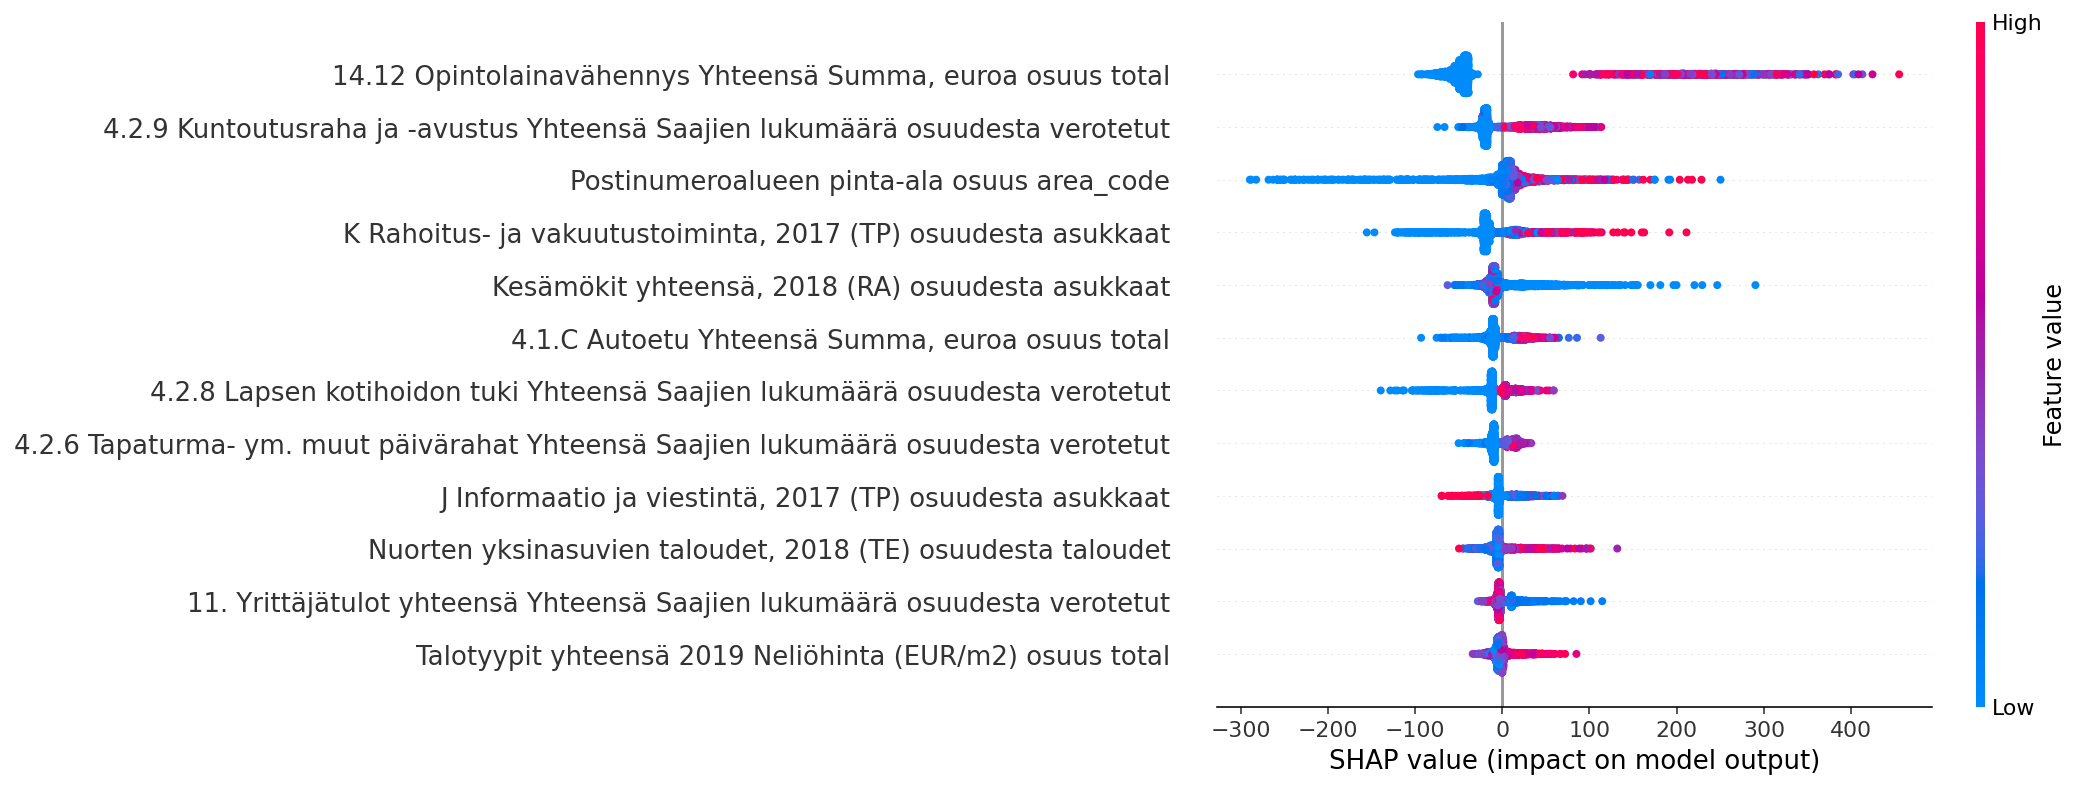

In [29]:
party ='PS'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = True

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


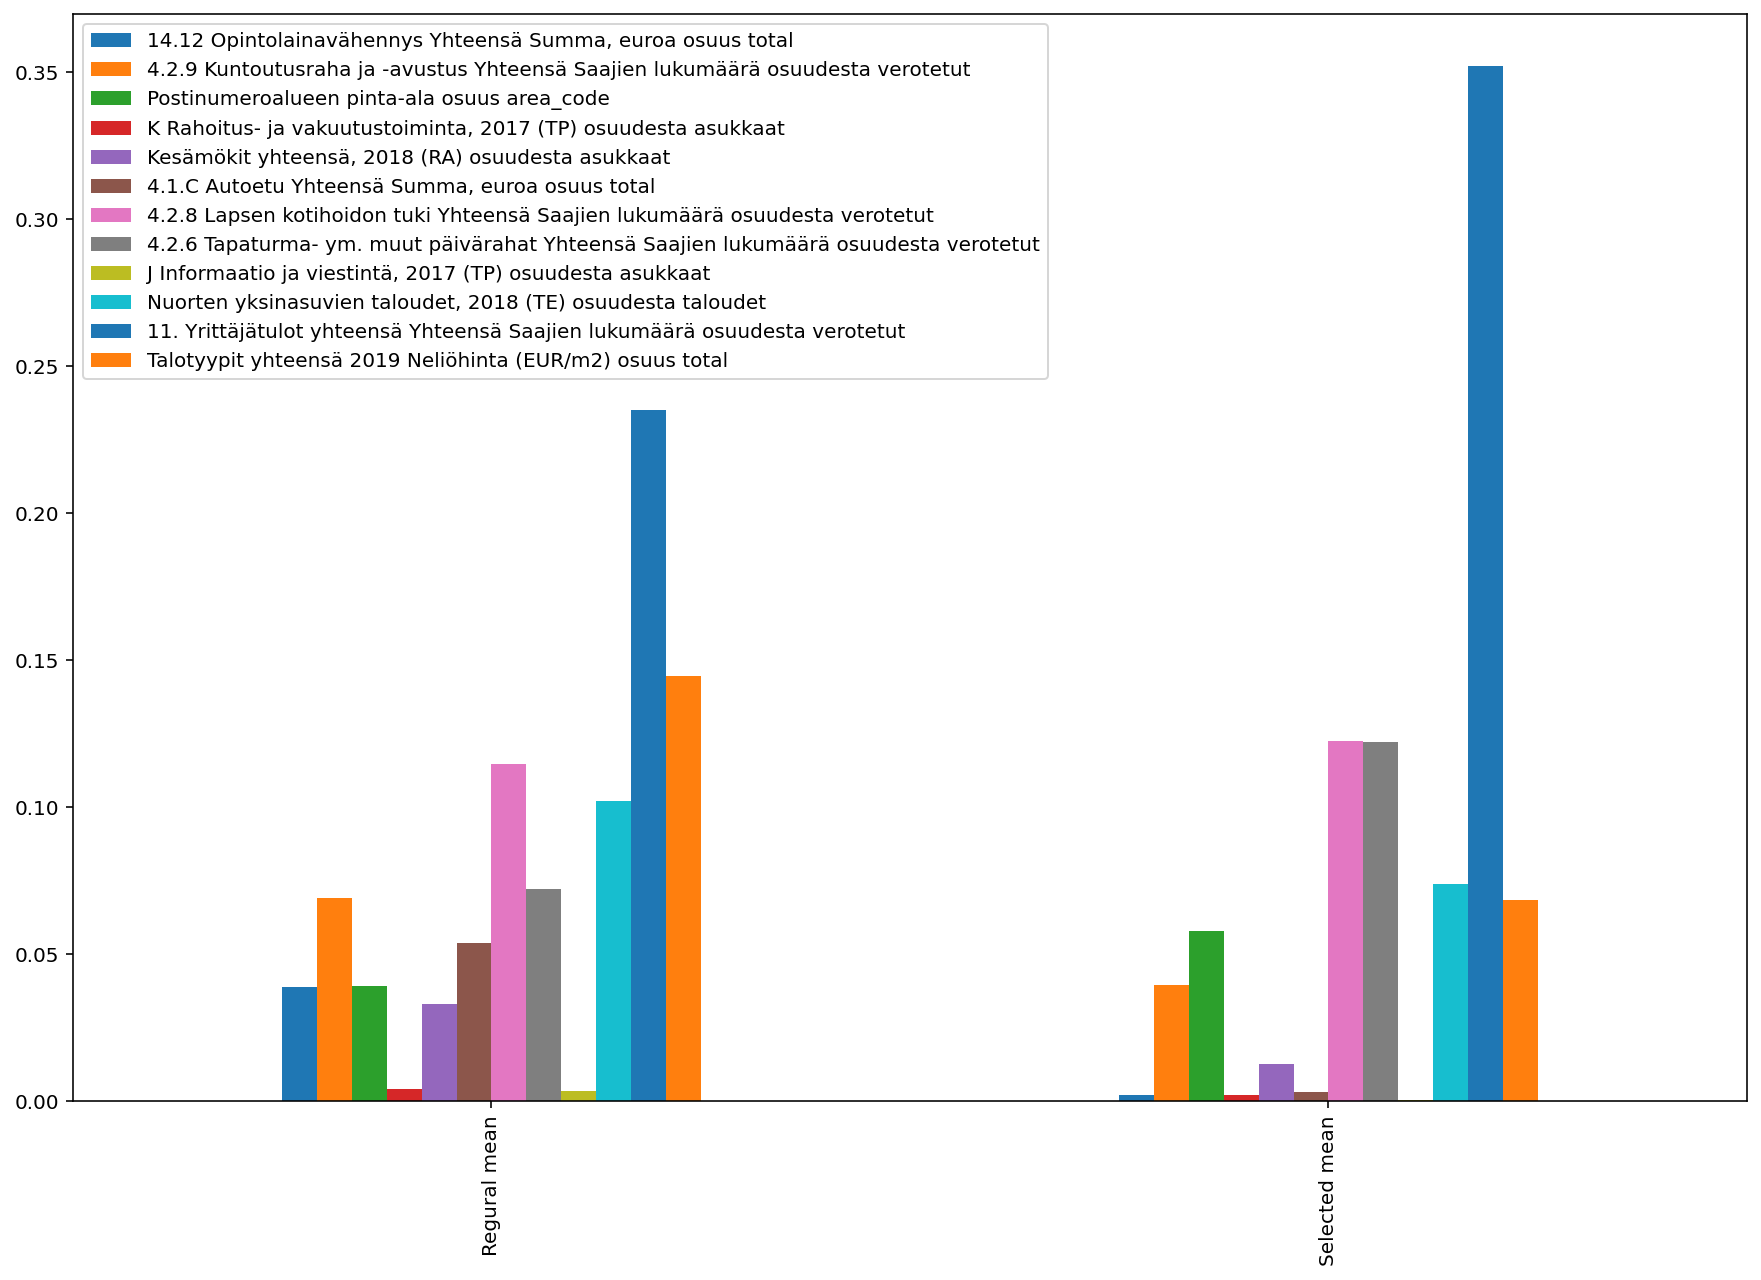

In [30]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=12, scaled=scaled)

In [31]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1187       39920    SUOMIJÄRVI           Karvia                         162.0   
1190       39960       SARVELA           Karvia                         435.0   
1163       38840     NIINISALO       Kankaanpää                         788.0   
1162       38770       LOHIKKO       Kankaanpää                         421.0   
1168       38950     HONKAJOKI        Honkajoki                        1260.0   

     Suurin_puolue  Ääniosuus PS  \
1187          KESK      0.372414   
1190          KESK      0.368932   
1163            PS      0.372765   
1162            PS      0.381443   
1168            PS      0.422222   

      Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
1187                                                  0.000000   
1190                                                  0.000000   
1163                                                  0.794245   
1162                                                  0.794245   
1168                                                  0.000000   

      Postinumeroalueen pinta-ala osuus area_code  \
1187                                     0.011298   
1190                                     0.007389   
1163                                     0.016901   
1162                                     0.003328   
1168                                     0.031554   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
1187                                          0.333333   
1190                                          0.266667   
1163                                          0.059645   
1162                                          0.057007   
1168                                          0.094444   

      J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
1187                                                       0.0   
1190                                                       0.0   
1163                                                       0.0   
1162                                                       0.0   
1168                                                       0.0   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
1187                                                       0.000000   
1190                                                       0.000000   
1163                                                       0.001269   
1162                                                       0.000000   
1168                                                       0.004762   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
1187                                                     0.013158   
1190                                                     0.020513   
1163                                                     0.044386   
1162                                                     0.018405   
1168                                                     0.046589   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
1187                                                                   0.229630   
1190                                                                   0.159036   
1163                                                                   0.133942   
1162                                                                   0.170330   
1168                                                                   0.190819   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
1187                                                                             0.000000   
1190                                                                             0.000000   
1163                                                                             0.016743   
1162                                                                             0.000000   
1168                             

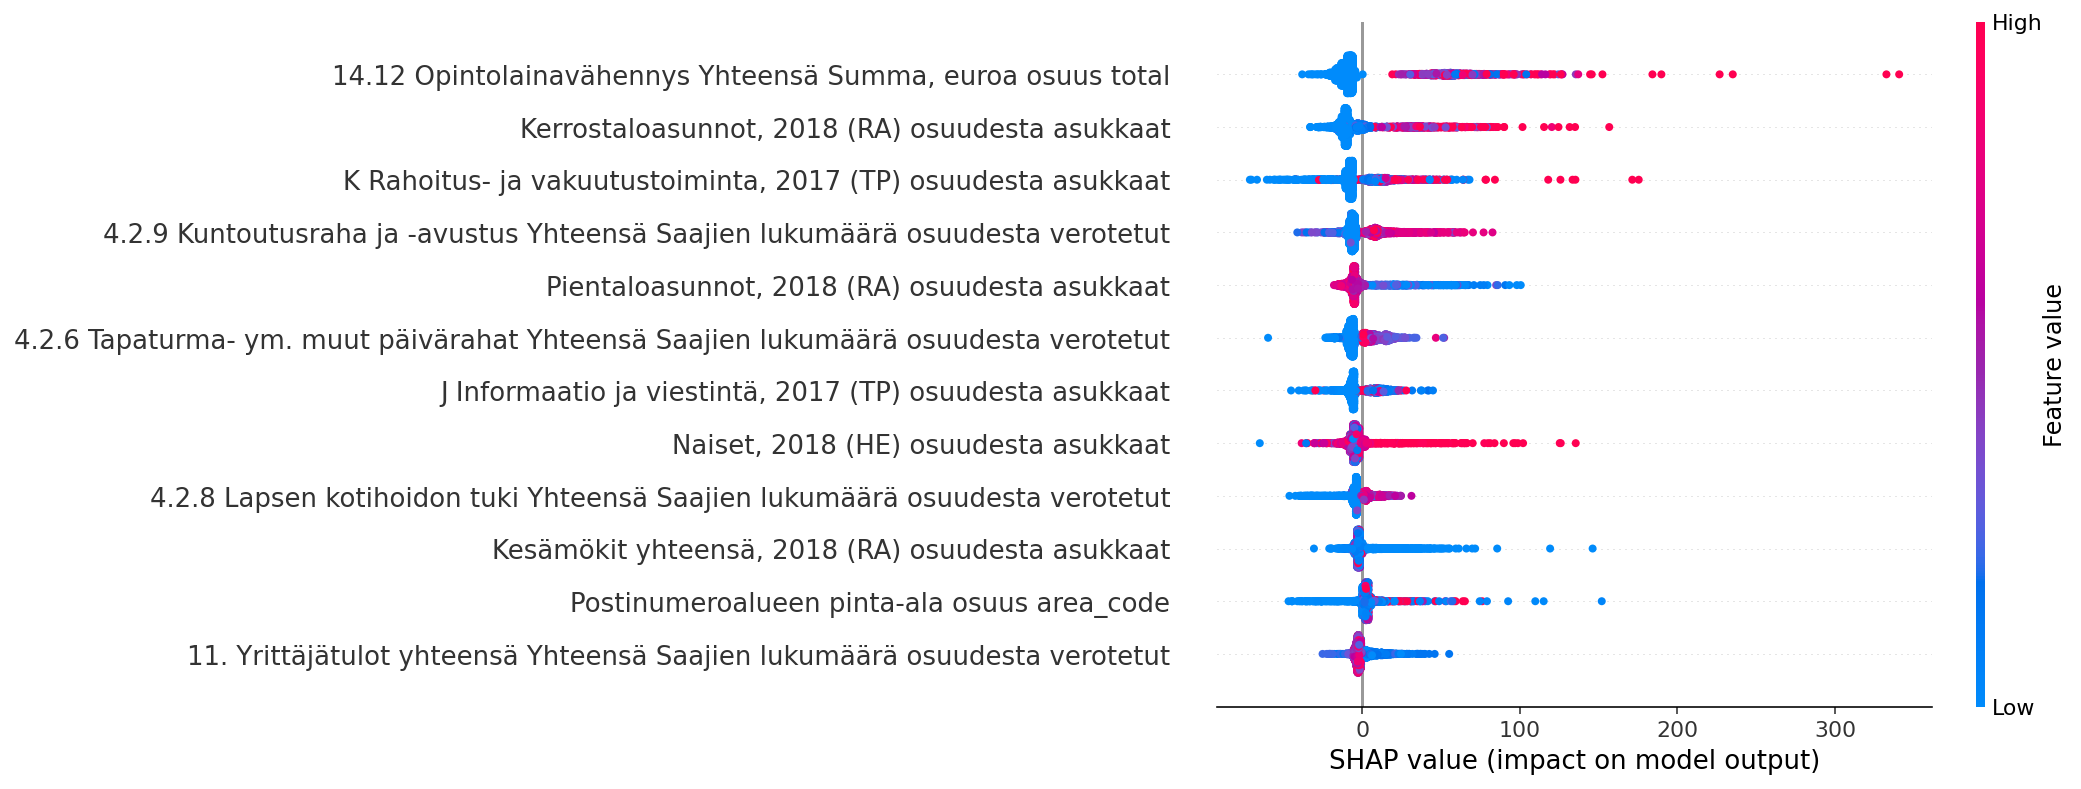

In [32]:
party ='VAS'
aaniosuus = 'Ääniosuus ' + party
aanet = 'Äänet yhteensä lkm ' + party
shap_index = list_of_parties.index(party)
included_columns = []
compare_value = 2
columns = 12
scaled = True

compared_value = compare_value * (data[aanet].sum()/data['Äänet yhteensä lkm Äänet'].sum())
compare_to = data[(data[aaniosuus]) > compared_value].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


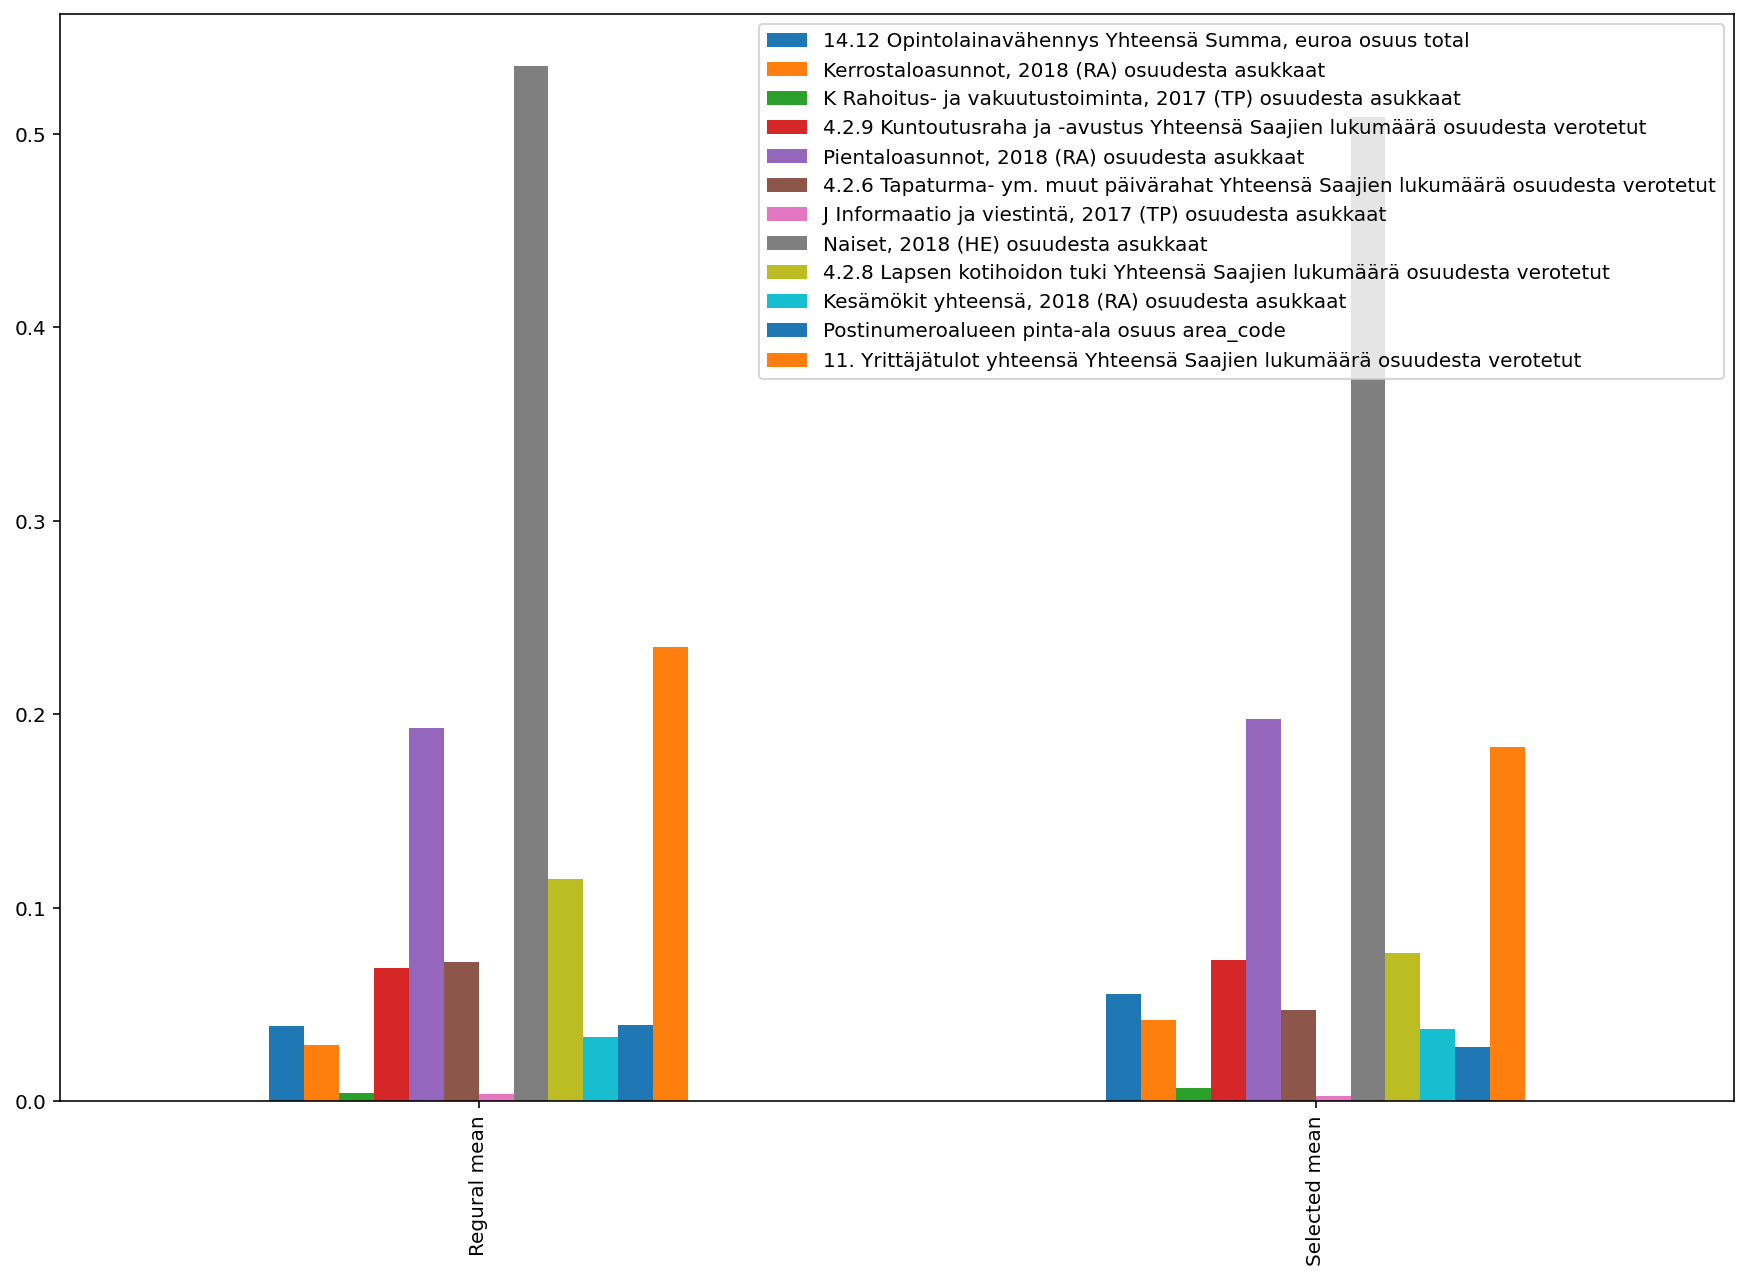

In [33]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

In [34]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue', aaniosuus]
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero  postcode_name muncipality_name  \
2938       98950          SAIJA            Salla   
2535       88380      MIESLAHTI          Paltamo   
2890       98440   KALLAANVAARA        Kemijärvi   
2515       87150        KAJAANI          Kajaani   
2583       89920  RUHTINANSALMI      Suomussalmi   

      Asukkaat yhteensä, 2018 (HE) Suurin_puolue  Ääniosuus VAS  \
2938                         130.0          KESK       0.211382   
2535                         229.0          KESK       0.175926   
2890                         822.0          KESK       0.195455   
2515                        2266.0           VAS       0.236185   
2583                         317.0          KESK       0.195531   

      Naiset, 2018 (HE) osuudesta asukkaat  \
2938                              0.430769   
2535                              0.471616   
2890                              0.489051   
2515                              0.484554   
2583                              0.447950   

      Postinumeroalueen pinta-ala osuus area_code  \
2938                                     0.004761   
2535                                     0.003671   
2890                                     0.000179   
2515                                     0.000078   
2583                                     0.037839   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
2938                                         0.000000   
2535                                         0.000000   
2890                                         0.180049   
2515                                         0.071492   
2583                                         0.000000   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
2938                                          0.853846   
2535                                          0.292576   
2890                                          0.010949   
2515                                          0.000000   
2583                                          0.971609   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
2938                                       0.661538   
2535                                       0.480349   
2890                                       0.394161   
2515                                       0.404678   
2583                                       0.690852   

      J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
2938                                                       0.0   
2535                                                       0.0   
2890                                                       0.0   
2515                                                       0.0   
2583                                                       0.0   

      K Rahoitus- ja vakuutustoiminta, 2017 (TP) osuudesta asukkaat  \
2938                                                       0.000000   
2535                                                       0.000000   
2890                                                       0.001217   
2515                                                       0.000000   
2583                                                       0.000000   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
2938                                                                   0.250000   
2535                                                                   0.159574   
2890                                                                   0.068116   
2515                                                                   0.055349   
2583                                                                   0.200000   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
2938                                                                             0.000000   
2535                                                                             0.000000   
2890                                                                

In [35]:
from show_election_result import show_election_result
show_election_result(data, vaalidata, target_col_start, list_of_parties)

VIHR  lasketut äänet: Aitotulos  354152 Laskennallinen  344923 Ennuste  336235
Laskennallisen virhe aitoon tulokseen 2.606 %
Ennusteen virhe aitoon tulokseen 5.059 %
Ennusteen virhe laskennalliseen tulokseen 2.519 %

KOK  lasketut äänet: Aitotulos  523924 Laskennallinen  514711 Ennuste  516345
Laskennallisen virhe aitoon tulokseen 1.758 %
Ennusteen virhe aitoon tulokseen 1.447 %
Ennusteen virhe laskennalliseen tulokseen -0.317 %

SDP  lasketut äänet: Aitotulos  546263 Laskennallinen  538953 Ennuste  545022
Laskennallisen virhe aitoon tulokseen 1.338 %
Ennusteen virhe aitoon tulokseen 0.227 %
Ennusteen virhe laskennalliseen tulokseen -1.126 %

KD  lasketut äänet: Aitotulos  120019 Laskennallinen  117310 Ennuste  118643
Laskennallisen virhe aitoon tulokseen 2.257 %
Ennusteen virhe aitoon tulokseen 1.147 %
Ennusteen virhe laskennalliseen tulokseen -1.136 %

KESK  lasketut äänet: Aitotulos  423511 Laskennallinen  415388 Ennuste  414784
Laskennallisen virhe aitoon tulokseen 1.918 %
Ennustee

Yksittäinen pnro

In [36]:
pnro = '00100'
id_col = 'Postinumero'
party ='KOK'
key = 'Äänet yhteensä lkm ' + party
idx = data[data[id_col]==pnro].index.item()
prt_number = list_of_parties.index(party)

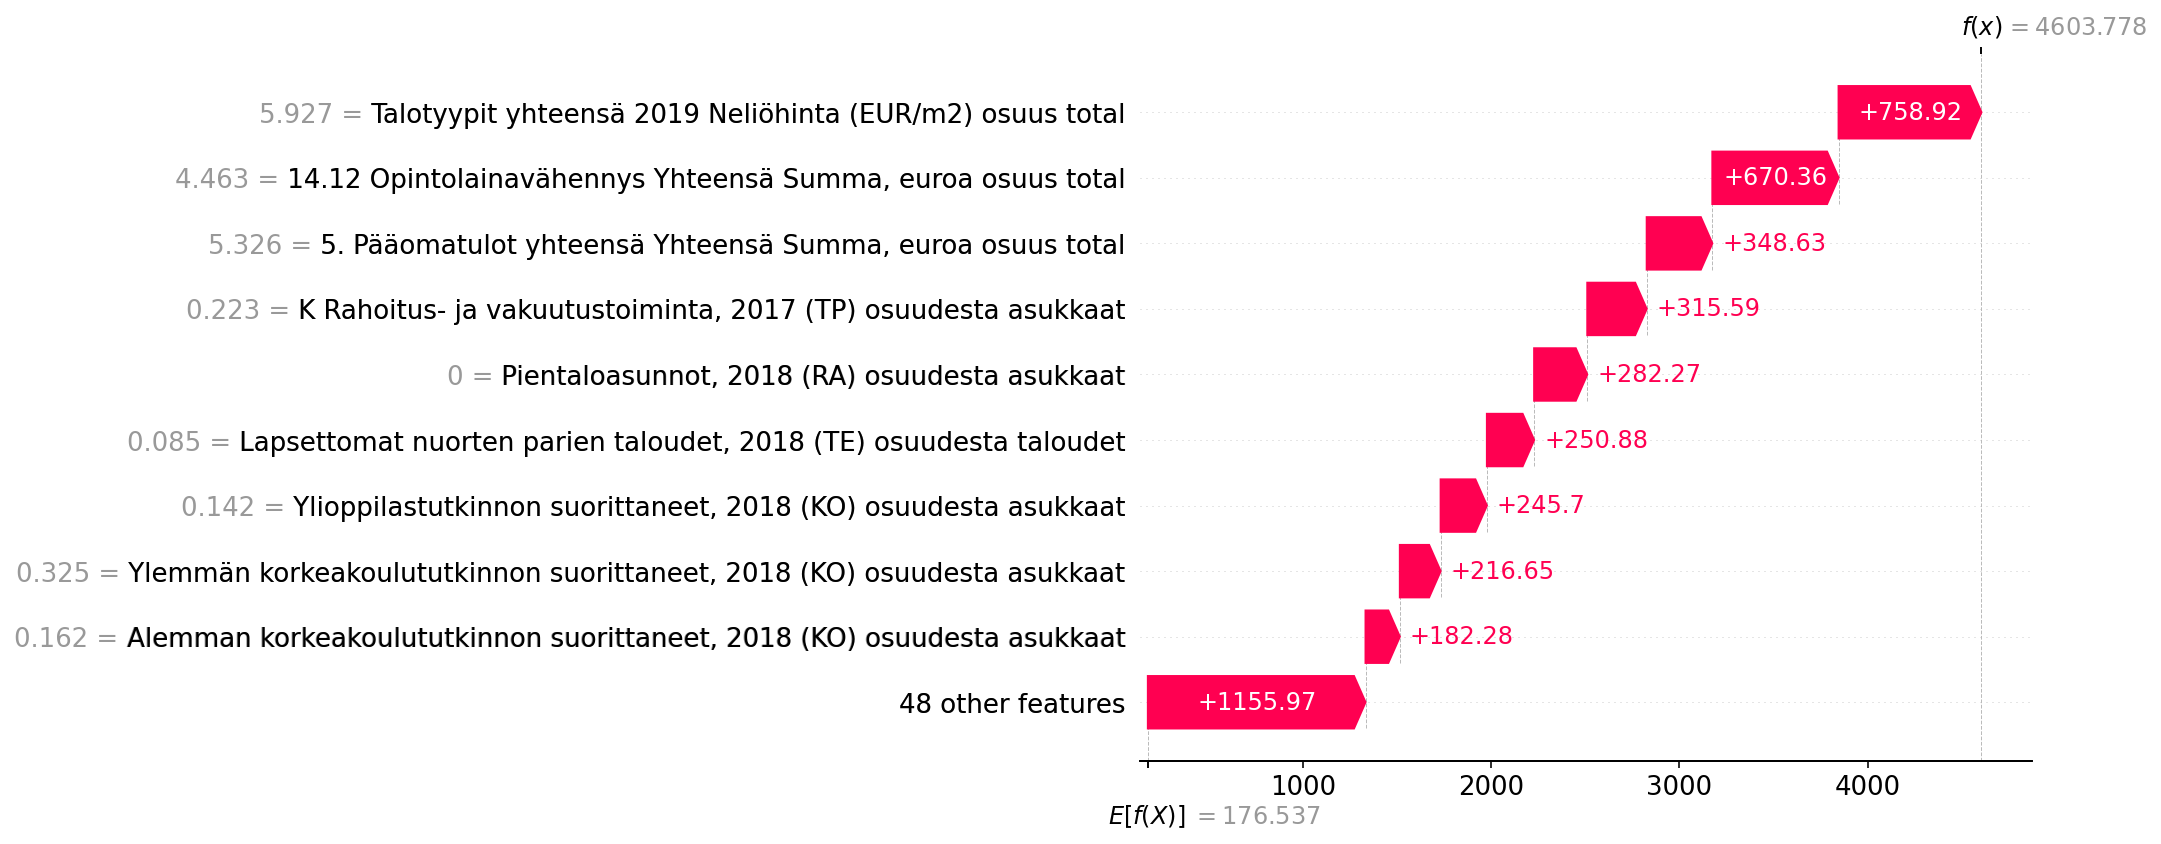

In [37]:
shap.waterfall_plot(shap_expected_value[prt_number], shap_values[prt_number][idx], X.iloc[idx,:], max_display=10)